In [1]:
import tensorflow as tf
sess = tf.Session()
from keras import backend as K
K.set_session(sess)
from osgeo import ogr, osr

import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os

import rasterio
from rasterio.transform import from_origin
from tqdm import tnrange, tqdm_notebook
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, constants
from scipy.ndimage import median_filter
from skimage.transform import resize

Using TensorFlow backend.


In [2]:
#new_saver.save(sess, "../models/niger-current/model")

In [3]:
new_saver = tf.train.import_meta_graph('../models/january-super-africa/model.meta')
new_saver.restore(sess, tf.train.latest_checkpoint('../models/january-super-africa/'))


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../models/january-super-africa/model


In [4]:
# setup function to reproject coordinates
EPSG = CRS.WGS84
def convertCoords(xy, src='', targ=''):

    srcproj = osr.SpatialReference()
    srcproj.ImportFromEPSG(src)
    targproj = osr.SpatialReference()
    if isinstance(targ, str):
        targproj.ImportFromProj4(targ)
    else:
        targproj.ImportFromEPSG(targ)
    transform = osr.CoordinateTransformation(srcproj, targproj)

    pt = ogr.Geometry(ogr.wkbPoint)
    pt.AddPoint(xy[0], xy[1])
    pt.Transform(transform)
    return([pt.GetX(), pt.GetY()])

def bounding_box(point, x_offset_max = 140, y_offset_max = 140, expansion = 10):
    # LONG, LAT FOR SOME REASON
    tl = point
    
    if 102 <= tl[0] <= 109:
        epsg = 32648 if tl[1] > 0 else 32748
    if 96 <= tl[0] <= 102:
        epsg = 32647 if tl[1] > 0 else 32747
    if 90 <= tl[0] <= 96:
        epsg = 32646 if tl[1] > 0 else 32746
    if 84 <= tl[0] <= 90:
        epsg = 32645 if tl[1] > 0 else 32745
    if 78 <= tl[0] <= 84:
        epsg = 32644 if tl[1] > 0 else 32744
    if 72 <= tl[0] <= 78:
        epsg = 32643 if tl[1] > 0 else 32743
    if 66 <= tl[0] <= 72:
        epsg = 32642 if tl[1] > 0 else 32742
    if 60 <= tl[0] <= 66:
        epsg = 32641 if tl[1] > 0 else 32741
    if 54 <= tl[0] <= 60:
        epsg = 32640 if tl[1] > 0 else 32740
    if 48 <= tl[0] <= 54:
        epsg = 32639 if tl[1] > 0 else 32739
    if 42 <= tl[0] <= 48:
        epsg = 32638 if tl[1] > 0 else 32738
    if 36 <= tl[0] <= 42:
        epsg = 32637 if tl[1] > 0 else 32737
    if 30 <= tl[0] <= 36:
        epsg = 32636 if tl[1] > 0 else 32736
    if 24 <= tl[0] <= 30:
        epsg = 32635 if tl[1] > 0 else 32735
    if 18 <= tl[0] <= 24:
        epsg = 32634 if tl[1] > 0 else 32734
    if 12 <= tl[0] <= 18:
        epsg = 32633 if tl[1] > 0 else 32733
    if 6 <= tl[0] <= 12:
        epsg = 32632 if tl[1] > 0 else 32732
    if 0 <= tl[0] <= 6:
        epsg = 32631 if tl[1] > 0 else 32731
    if -6 <= tl[0] <= 0:
        epsg = 32630 if tl[1] > 0 else 32730
    if -12 <= tl[0] <= -6:
        epsg = 32629 if tl[1] > 0 else 32729
    if -18 <= tl[0] <= -12:
        epsg = 32628 if tl[1] > 0 else 32728
    if -24 <= tl[0] <= -18:
        epsg = 32627 if tl[1] > 0 else 32727
    if -30 <= tl[0] <= -24:
        epsg = 32626 if tl[1] > 0 else 32726
    if -36 <= tl[0] <= -30:
        epsg = 32625 if tl[1] > 0 else 32725
    if -42 <= tl[0] <= -36:
        epsg = 32624 if tl[1] > 0 else 32724
    if -48 <= tl[0] <= -42:
        epsg = 32623 if tl[1] > 0 else 32723
    if -78 <= tl[0] <= -72:
        epsg = 32618 if tl[1] > 0 else 32718
    if -84 <= tl[0] <= -78:
        epsg = 32617 if tl[1] > 0 else 32717
    if -90 <= tl[0] <= -84:
        epsg = 32616 if tl[1] > 0 else 32716
    if -96 <= tl[0] <= -90:
        epsg = 32615 if tl[1] > 0 else 32715
    if -102 <= tl[0] <= -96:
        epsg = 32614 if tl[1] > 0 else 32714
    if -108 <= tl[0] <= -102:
        epsg = 32613 if tl[1] > 0 else 32713
    if -114 <= tl[0] <= -108:
        epsg = 32612 if tl[1] > 0 else 32712
    if -120 <= tl[0] <= -114:
        epsg = 32611 if tl[1] > 0 else 32711
    if -126 <= tl[0] <= -120:
        epsg = 32610 if tl[1] > 0 else 32710
        
        

    tl = convertCoords(tl, 4326, epsg)
    
    br = (tl[0], tl[1])
    tl = ((tl[0] + (x_offset_max)), (tl[1] + (y_offset_max )))
    distance1 = tl[0] - br[0]
    distance2 = tl[1] - br[1]
    #EXPANSION = (expansion - np.mean([distance1, distance2]))/2 # should this be 155 or 160?
    
    br = [a - expansion for a in br]
    tl = [a + expansion for a in tl]
    
    after = [b - a for a,b in zip(br, tl)]
    print(after)
    #br = (br[0] + 20, br[1] + 20)
    #tl = (tl[0] - 20, tl[1] - 20)
    br = convertCoords(br, epsg, 4326)
    tl = convertCoords(tl, epsg, 4326)
    
    min_x = tl[0] # original X offset - 10 meters
    max_x = br[0] # original X offset + 10*GRID_SIZE meters
    
    min_y = tl[1] # original Y offset - 10 meters
    max_y = br[1] # original Y offset + 10 meters + 140 meters
    # (min_x, min_y), (max_x, max_y)
    # (bl, tr)
    return [(min_x, min_y), (max_x, max_y)]

81 64 72 72 289


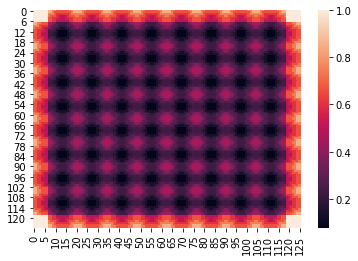

In [5]:
arr = np.array([[1, 1, 2, 2, 3, 3, 3],
                [1, 1, 2, 3, 3, 3, 3],
                [2, 2, 2, 3, 4, 4, 4],
                [2, 3, 3, 3, 4, 5, 6],
                [3, 3, 4, 4, 4, 5, 6],
                [3, 3, 4, 4, 5, 5, 6], 
                [3, 3, 4, 4, 6, 6, 6]])

#arr = np.array(
#      [[0, 0, 0, 0, 0, 0, 0],
#       [0, 1, 1, 1, 1, 1, 1],
#       [0, 1, 2, 2, 2, 2, 2],
#       [0, 1, 2, 3, 3, 3, 3],
#       [0, 1, 2, 3, 4, 4, 4],
#       [0, 1, 2, 3, 4, 5, 5], 
#       [0, 1, 2, 3, 4, 5, 6]])

arr = arr / 6


SIZE = 9
SIZE_N = SIZE*SIZE
SIZE_UR = (SIZE - 1) * (SIZE - 1)
SIZE_R = (SIZE - 1) * SIZE
SIZE_U = SIZE_R
TOTAL = SIZE_N + SIZE_UR + SIZE_R + SIZE_U
print(SIZE_N, SIZE_UR, SIZE_R, SIZE_U, TOTAL)


arr = np.concatenate([arr, np.flip(arr, 0)], 0)
base_filter = np.concatenate([arr, np.flip(arr, 1)], 1)
normal = np.tile(base_filter, (SIZE, SIZE))
normal[:, 0:7] = 1.
normal[:, -7:] = 1.
normal[0:7, :] = 1.
normal[-7:, :] = 1.
upright = np.tile(base_filter, (SIZE - 1, SIZE - 1))
upright = np.pad(upright, (7, 7), 'constant', constant_values = 0)
right_filter = np.tile(base_filter, (SIZE, SIZE - 1))
right_filter = np.pad(right_filter, ((0, 0), (7, 7)), 'constant', constant_values = 0)
up_filter = np.tile(base_filter, (SIZE - 1, SIZE))
up_filter = np.pad(up_filter, ((7, 7), (0, 0)), 'constant', constant_values = 0)

sums = (up_filter + right_filter + upright + normal)
up_filter /= sums
right_filter /= sums
upright /= sums
normal /= sums
sns.heatmap(normal)



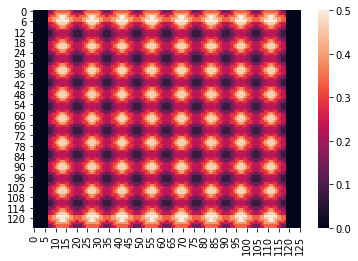

In [6]:
sns.heatmap(right_filter)

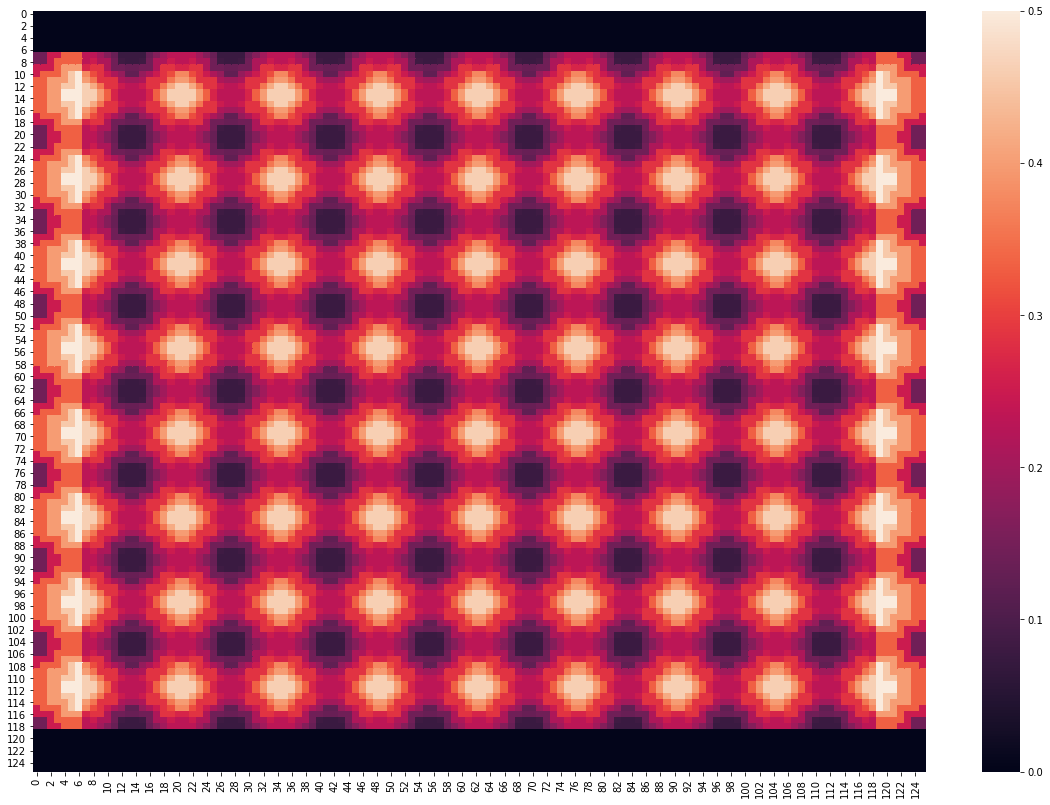

In [7]:
plt.figure(figsize=(20, 14))
sns.heatmap(up_filter)

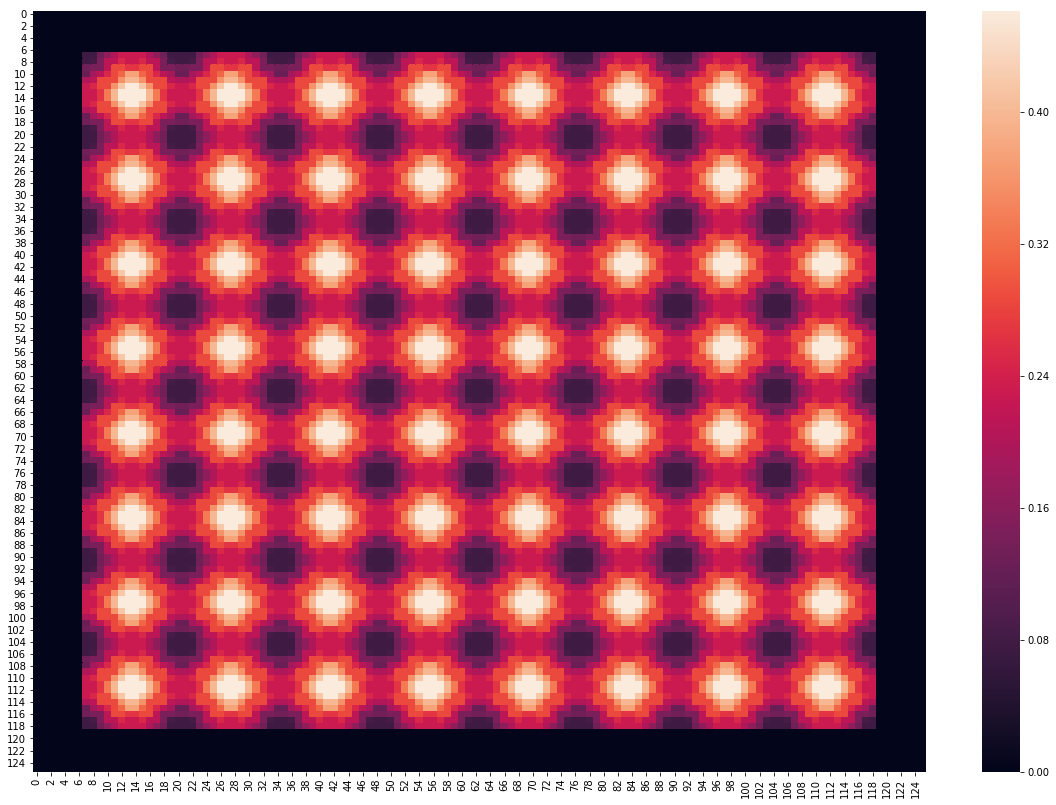

In [8]:
plt.figure(figsize=(20, 14))
sns.heatmap(upright[:, :])

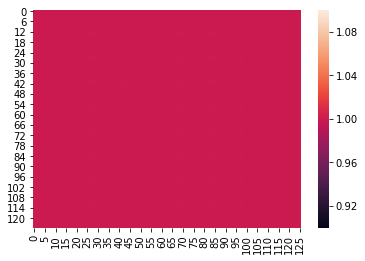

In [9]:
sum_filter = (upright + normal+right_filter + up_filter)# + right_filter + up_filter)
sns.heatmap(sum_filter)

In [10]:
np.tile(np.array(24), (24, 1)).shape

(24, 1)

In [11]:
# December 10-11 model, validated-size, filled in by train-l2a-dec
min_all = [0.019788351394236087,
 0.0376599433645606,
 0.022249658703804017,
 0.09112316101789475,
 0.06029978767037392,
 0.08587831154465678,
 0.09322187490761281,
 0.10038416087627411,
 0.09066671133041382,
 0.04962744191288948,
 0.0,
 0.010814227256923915,
 -0.020943850725889203,
 0.008634393354877836]

max_all = [0.17124534726142882,
 0.2569628745317458,
 0.3763543248176573,
 0.4688883873820304,
 0.422776158452034,
 0.44434353709220886,
 0.4722869098186493,
 0.4879453480243683,
 0.6069133794307708,
 0.5277097404003142,
 0.36966854333877563,
 0.69947146654129,
 0.39734595388174054,
 0.6361596417427062]

def tile_images(arr, output_folder):
    i = 0
    # Normal
    images = []
    for x_offset, cval in enumerate([x for x in range(0, 126, 14)]):
        for y_offset, rval in enumerate([x for x in range(0, 126, 14)]):
            base_id = 0
            subs = arr[:, cval:cval+16, rval:rval+16]
            images.append(subs)
            #np.save(output_folder + str(base_id+x_offset*9+y_offset+1), subs)
            
    # Upright        
    for x_offset, cval in enumerate([x for x in range(7,  119, 14)]):
        for y_offset, rval in enumerate([x for x in range(7, 119, 14)]):
            base_id = 9*9
            subs = arr[:, cval:cval+16, rval:rval+16]
            images.append(subs)
            #np.save(output_folder + str(base_id+x_offset*8+y_offset+1), subs)
            
    # Right
    for x_offset, cval in enumerate([x for x in range(7, 119, 14)]):
        for y_offset, rval in enumerate([x for x in range(0, 126, 14)]):
            base_id = (9*9)+(8*8)
            subs = arr[:, cval:cval+16, rval:rval+16]
            images.append(subs)
            #np.save(output_folder + str(base_id+x_offset*9+y_offset+1), subs)
            
    # Up
    for x_offset, cval in enumerate([x for x in range(0, 119, 14)]):
        for y_offset, rval in enumerate([x for x in range(7, 119, 14)]):
            base_id = (9*9)+(8*8)+(9*8)
            subs = arr[:, cval:cval+16, rval:rval+16]
            images.append(subs)
    return images
            #np.save(output_folder + str(base_id+x_offset*8+y_offset+1), subs)



def load_and_predict_folder(y_col, folder, overlap_filter = upright, normal_filter = normal):
    #pred_files = ["../data/oregon/" + str(y_col) + "/" + str(folder) + "/" + str(x) + ".npy" for x in range(1, TOTAL+1)]
    pred_files = ["../data/tigray/" + str(y_col) + "/" + str(folder) + ".npy"]
    #pred_x = np.empty((0, 24, 16, 16, 14))
    pred_x = []

    for i in range(len(pred_files)):
        x = np.load(pred_files[0])
        
        filtered = median_filter(x[0, :, :, 10], size = 5)
        filtered = np.reshape(filtered, (64, 2, 64, 2))
        filtered = np.mean(filtered, axis = (1, 3))
        filtered = resize(filtered, (128, 128), 0)
        #if x.shape[0] < 24:
        #    padding = np.tile(x[-1, :, :, :], (24-x.shape[0], 1, 1, 1))
        #    x = np.concatenate((x, padding), axis = 0)
        x[:, :, :, 10] = np.stack([filtered] * 24)
        x = np.delete(x, -1, -1)
        x = tile_images(x, None)
  
    pred_x = np.stack(x)
        
    
    for x in range(0, pred_x.shape[-1]):
        mins = min_all[x]
        maxs = max_all[x]
        pred_x[:, :, :, :, x] = np.clip(pred_x[:, :, :, :, x], mins, maxs)
        midrange = (maxs + mins) / 2
        rng = maxs - mins
        standardized = (pred_x[:, :, :, :, x] - midrange) / (rng / 2)
        pred_x[:, :, :, :, x] = standardized
        mins, maxs = (np.min(pred_x[:, :, :, :, x]), np.max(pred_x[:, :, :, :, x]))
        
    preds = []
    batches = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 289]
    for i in range(len(batches)-1):
        batch_x = pred_x[batches[i]:batches[i+1]]
        #lengths = np.array(24).tile((batch_x.shape[0], 1))
        lengths = np.tile(np.array(24), (batch_x.shape[0], 1))
        batch_pred = sess.run(logits, feed_dict={inp:batch_x, length:lengths}).reshape(batch_x.shape[0], 14, 14)
        for sample in range(batch_pred.shape[0]):
            preds.append(batch_pred[sample, :, :])
        
    preds_stacked = []
    for i in range(0, SIZE_N, SIZE):
        preds_stacked.append(np.concatenate(preds[i:i + SIZE], axis = 1))
    stacked = np.concatenate(preds_stacked, axis = 0)
    stacked = stacked * normal
        
    preds_overlap = []
    for scene in range(SIZE_N, SIZE_N+SIZE_UR, SIZE - 1):
        to_concat = np.concatenate(preds[scene:scene+ (SIZE - 1)], axis = 1)
        preds_overlap.append(to_concat)    
    overlapped = np.concatenate(preds_overlap, axis = 0)
    overlapped = np.pad(overlapped, (7, 7), 'constant', constant_values = 0)
    overlapped = overlapped * upright
        
    preds_up = []
    for scene in range(SIZE_N+SIZE_UR, SIZE_N+SIZE_UR+SIZE_R, SIZE):
        to_concat = np.concatenate(preds[scene:scene+SIZE], axis = 1)
        preds_up.append(to_concat)   
    up = np.concatenate(preds_up, axis = 0)
    up = np.pad(up, ((7,7), (0,0)), 'constant', constant_values = 0)
    up = up * up_filter
        
    preds_right = []
    for scene in range(SIZE_N+SIZE_UR+SIZE_R, TOTAL, SIZE - 1):
        to_concat = np.concatenate(preds[scene:scene+SIZE-1], axis = 1)
        preds_right.append(to_concat)   
    right = np.concatenate(preds_right, axis = 0)
    right = np.pad(right, ((0, 0), (7, 7)), 'constant', constant_values = 0)
    right = right * right_filter
    
    stacked = stacked + overlapped + right + up
    #stacked = stacked / sum_filter
    return stacked

In [12]:
for i in range(50):
    try:
        logits = tf.get_default_graph().get_tensor_by_name("conv2d_{}/Sigmoid:0".format(i))
    except Exception:
        pass
    

In [13]:
#logits = tf.get_default_graph().get_tensor_by_name("conv2d_11/Sigmoid:0")
inp = tf.get_default_graph().get_tensor_by_name("Placeholder:0")
length = tf.get_default_graph().get_tensor_by_name("Placeholder_1:0")

In [14]:
x = np.load("../data/tigray/0/0.npy")






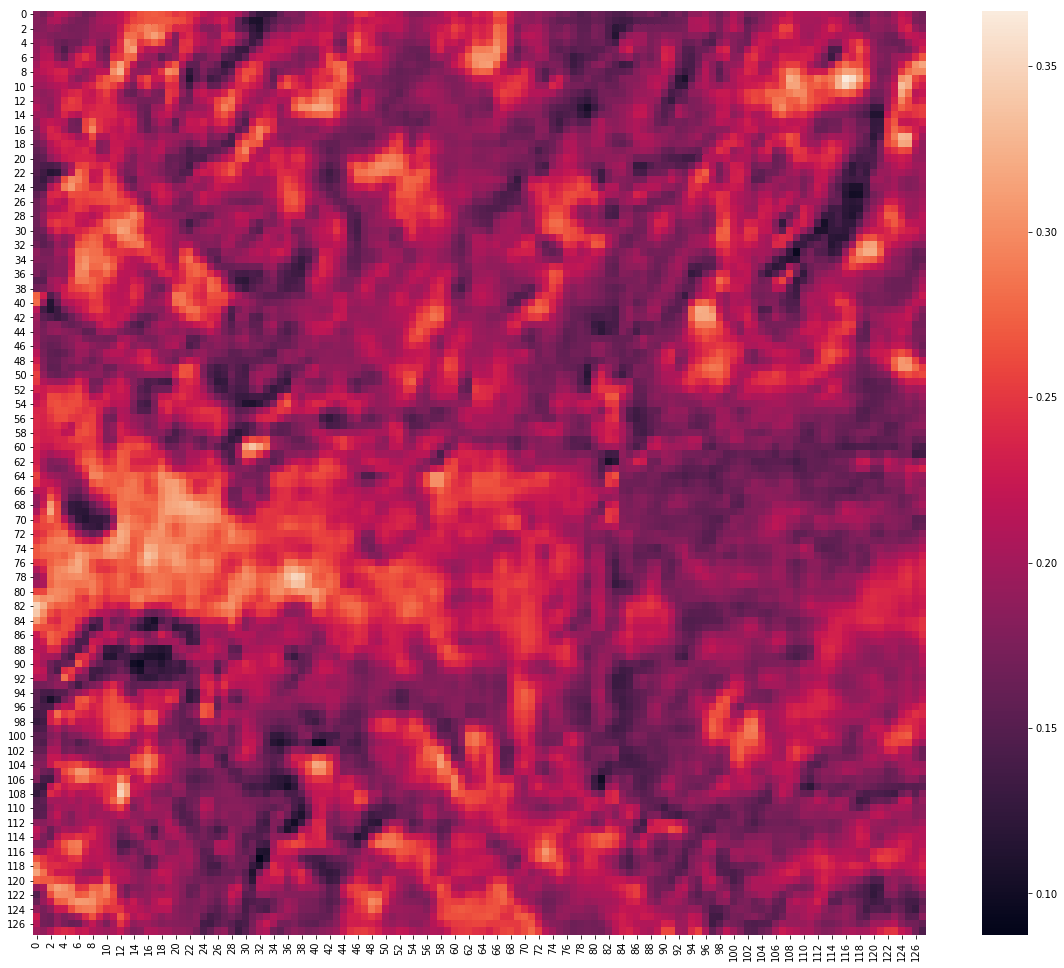

In [15]:
plt.figure(figsize=(20, 17))
sns.heatmap(x[1, :, :, 5])




In [18]:
from time import sleep
all_preds = []
for row in tnrange(0,10):
    pred_i = [load_and_predict_folder(row, col) for col in range(0, 15)]
    pred_i = np.concatenate(pred_i, axis = 1)
    all_preds.append(pred_i)
    sleep(3)
all_preds.reverse()
stacked = np.concatenate(all_preds, axis = 0)
#stacked, overalpped, up, right = load_and_predict_folder(0, 0)

In [34]:
stacked = np.concatenate(all_preds, axis = 0)
plt.figure(figsize=(20, 13))
#sns.heatmap(stacked)
#plt.savefig('ghana.png', dpi = 300)

<Figure size 1440x936 with 0 Axes>

<Figure size 1440x936 with 0 Axes>

In [35]:
thresh = 0.16 # .4, .44 for makueni, 65, 75 for kochi
thresh_p = 0.32

for window_x in range(2, stacked.shape[0]-2, 1):
    for window_y in range(2, stacked.shape[1]-2, 1):
        l, r, u, d =  False, False, False, False
        cur_window = stacked[window_x-2:window_x+3, window_y-2:window_y+3]
        hor_vert_neighbors = False
        if (cur_window[2, 2] > thresh and
            cur_window[2, 2] < thresh_p):
            if cur_window[3, 2] > thresh and cur_window[4, 2] < thresh:
                hor_vert_neighbors = True
                r = True
            if cur_window[1, 2] > thresh and cur_window[2, 0] < thresh:
                hor_vert_neighbors = True
                l = True
            if cur_window[2, 3] > thresh and cur_window[2, 4] < thresh:
                hor_vert_neighbors = True
                d = True
            if cur_window[2, 1] > thresh and cur_window[2, 0] < thresh:
                hor_vert_neighbors = True
                u = True
        passes = False
        if r and not l:
            passes = True
        if l and not r:
            passes = True
        if d and not u:
            passes = True
        if u and not d:
            passes = True
        
        if passes:
            if r:
                if cur_window[1, 1] < thresh and cur_window[1, 3] < thresh:
                    print("Adding a tree with: {}".format(cur_window[2, 2]))
                    stacked[window_x, window_y] = (thresh_p + 0.01)
            
            if l:
                if cur_window[3, 1] < thresh and cur_window[3, 3] < thresh:
                    print("Adding a tree with: {}".format(cur_window[2, 2]))
                    stacked[window_x, window_y] = (thresh_p + 0.01)
                
            if u:
                if cur_window[1, 3] < thresh and cur_window[3, 3] < thresh:
                    print("Adding a tree with: {}".format(cur_window[2, 2]))
                    stacked[window_x, window_y] = (thresh_p + 0.01)
                
            if d:
                if cur_window[1, 1] < thresh and cur_window[3, 1] < thresh:
                    print("Adding a tree with: {}".format(cur_window[2, 2]))
                    stacked[window_x, window_y] = (thresh_p + 0.01)
                
            #n_offenders = 0
                
                #print(cur_window)

Adding a tree with: 0.3077523410320282
Adding a tree with: 0.19026772677898407
Adding a tree with: 0.2346961855888367
Adding a tree with: 0.3021663427352905
Adding a tree with: 0.33
Adding a tree with: 0.16070032119750977
Adding a tree with: 0.16944896429777145
Adding a tree with: 0.18409420053164163
Adding a tree with: 0.18041197955608368
Adding a tree with: 0.20215389728546146
Adding a tree with: 0.17710891366004944
Adding a tree with: 0.33
Adding a tree with: 0.19352322816848755
Adding a tree with: 0.16321510821580887
Adding a tree with: 0.24654638022184372
Adding a tree with: 0.20340386778116226
Adding a tree with: 0.28980693221092224
Adding a tree with: 0.2106095850467682
Adding a tree with: 0.16628507971763612
Adding a tree with: 0.23424166440963745
Adding a tree with: 0.23093587905168533
Adding a tree with: 0.20761469602584842
Adding a tree with: 0.33
Adding a tree with: 0.2243209540843964
Adding a tree with: 0.33
Adding a tree with: 0.21662715822458267
Adding a tree with: 0.263

Adding a tree with: 0.17252396390988273
Adding a tree with: 0.2617628368047567
Adding a tree with: 0.2000814696153005
Adding a tree with: 0.17377729140795192
Adding a tree with: 0.27070662975311277
Adding a tree with: 0.2530946791172028
Adding a tree with: 0.21061194340387981
Adding a tree with: 0.19194406500229466
Adding a tree with: 0.21204616030057272
Adding a tree with: 0.16190826694170635
Adding a tree with: 0.27215141745714033
Adding a tree with: 0.33
Adding a tree with: 0.2787167290846507
Adding a tree with: 0.18411924976568955
Adding a tree with: 0.33
Adding a tree with: 0.275404699643453
Adding a tree with: 0.19375206530094147
Adding a tree with: 0.28883941127703733
Adding a tree with: 0.23319154060803923
Adding a tree with: 0.16693119066102163
Adding a tree with: 0.33
Adding a tree with: 0.17475503683090207
Adding a tree with: 0.2343693444362053
Adding a tree with: 0.33
Adding a tree with: 0.20378801623980203
Adding a tree with: 0.33
Adding a tree with: 0.17927535909872785
Ad

Adding a tree with: 0.16565036347934178
Adding a tree with: 0.33
Adding a tree with: 0.26065836421081
Adding a tree with: 0.2620585986546108
Adding a tree with: 0.23101317456790382
Adding a tree with: 0.18364871186869486
Adding a tree with: 0.20978208099092757
Adding a tree with: 0.33
Adding a tree with: 0.2041331359318325
Adding a tree with: 0.18420888696398055
Adding a tree with: 0.18146470189094546
Adding a tree with: 0.21498171346528192
Adding a tree with: 0.21446060495717184
Adding a tree with: 0.2290277523653848
Adding a tree with: 0.3175521450383323
Adding a tree with: 0.1673687206847327
Adding a tree with: 0.17127204792840142
Adding a tree with: 0.29863631129264834
Adding a tree with: 0.1914718236242022
Adding a tree with: 0.16419474993433272
Adding a tree with: 0.33
Adding a tree with: 0.2794816613197327
Adding a tree with: 0.33
Adding a tree with: 0.21609751028673993
Adding a tree with: 0.1906869858503342
Adding a tree with: 0.16424089244433815
Adding a tree with: 0.238695427

Adding a tree with: 0.17375883885792326
Adding a tree with: 0.2126594547714506
Adding a tree with: 0.33
Adding a tree with: 0.2678897778193156
Adding a tree with: 0.2581691869667599
Adding a tree with: 0.2420059910842351
Adding a tree with: 0.16107055346171062
Adding a tree with: 0.22411407743181502
Adding a tree with: 0.2419740935166677
Adding a tree with: 0.28966235688754494
Adding a tree with: 0.20710494475705285
Adding a tree with: 0.33
Adding a tree with: 0.24598470926284793
Adding a tree with: 0.16831507640225546
Adding a tree with: 0.1869732907840184
Adding a tree with: 0.18806698492595128
Adding a tree with: 0.2729850901024682
Adding a tree with: 0.27717231852667673
Adding a tree with: 0.30411426510129663
Adding a tree with: 0.22728416721026107
Adding a tree with: 0.33
Adding a tree with: 0.18009178042411805
Adding a tree with: 0.2164306342601776
Adding a tree with: 0.20221021771430972
Adding a tree with: 0.16103117465972902
Adding a tree with: 0.27825568914413457
Adding a tree

Adding a tree with: 0.2369365145762761
Adding a tree with: 0.33
Adding a tree with: 0.2729488634146176
Adding a tree with: 0.18939463221109826
Adding a tree with: 0.33
Adding a tree with: 0.225470636288325
Adding a tree with: 0.2666741053263347
Adding a tree with: 0.19660597581129804
Adding a tree with: 0.2487841327985128
Adding a tree with: 0.20053980212945202
Adding a tree with: 0.22238179812064535
Adding a tree with: 0.1846787883685185
Adding a tree with: 0.26872204588009757
Adding a tree with: 0.33
Adding a tree with: 0.23028852847906253
Adding a tree with: 0.2475366016228994
Adding a tree with: 0.17125723224419812
Adding a tree with: 0.2727263619502385
Adding a tree with: 0.1829190598084376
Adding a tree with: 0.16841097076733907
Adding a tree with: 0.33
Adding a tree with: 0.20587691664695737
Adding a tree with: 0.33
Adding a tree with: 0.2729552388191223
Adding a tree with: 0.33
Adding a tree with: 0.21637702446717477
Adding a tree with: 0.2626455823580424
Adding a tree with: 0.

Adding a tree with: 0.2579809198012718
Adding a tree with: 0.165646514067283
Adding a tree with: 0.21901924482413704
Adding a tree with: 0.1642875795563062
Adding a tree with: 0.17764093833310263
Adding a tree with: 0.3024248331785202
Adding a tree with: 0.20469127808298385
Adding a tree with: 0.22916054725646975
Adding a tree with: 0.18707777772630962
Adding a tree with: 0.33
Adding a tree with: 0.20172900706529617
Adding a tree with: 0.22131456434726718
Adding a tree with: 0.19274493555227917
Adding a tree with: 0.28719656808035715
Adding a tree with: 0.30994283159573877
Adding a tree with: 0.1686836289508002
Adding a tree with: 0.20520195364952087
Adding a tree with: 0.23493057063647682
Adding a tree with: 0.20537319566522327
Adding a tree with: 0.18294320149081095
Adding a tree with: 0.27688281876700266
Adding a tree with: 0.1751104990641276
Adding a tree with: 0.1780011973210744
Adding a tree with: 0.1655871868133545
Adding a tree with: 0.17962688207626343
Adding a tree with: 0.20

Adding a tree with: 0.17212440712111338
Adding a tree with: 0.251154363155365
Adding a tree with: 0.2173401628221784
Adding a tree with: 0.19897512594858804
Adding a tree with: 0.28092510785375324
Adding a tree with: 0.3165310919284821
Adding a tree with: 0.33
Adding a tree with: 0.21607712762696407
Adding a tree with: 0.20183140890938897
Adding a tree with: 0.19926231460911886
Adding a tree with: 0.3022680679957072
Adding a tree with: 0.2466747164726258
Adding a tree with: 0.28021254284041275
Adding a tree with: 0.33
Adding a tree with: 0.2689516246318817
Adding a tree with: 0.1660281036581312
Adding a tree with: 0.27022799476981163
Adding a tree with: 0.16467530386788504
Adding a tree with: 0.21857816725969315
Adding a tree with: 0.21954945794173653
Adding a tree with: 0.16597177274525166
Adding a tree with: 0.23091016071183343
Adding a tree with: 0.2317607502142588
Adding a tree with: 0.33
Adding a tree with: 0.17077136039733887
Adding a tree with: 0.33
Adding a tree with: 0.2726404

Adding a tree with: 0.30342932618581325
Adding a tree with: 0.227541235940797
Adding a tree with: 0.1843833717016073
Adding a tree with: 0.33
Adding a tree with: 0.24018667389949164
Adding a tree with: 0.21318472283227108
Adding a tree with: 0.24922760895320345
Adding a tree with: 0.20923897624015808
Adding a tree with: 0.17497155567010245
Adding a tree with: 0.2639921350138528
Adding a tree with: 0.25190553920609615
Adding a tree with: 0.25115696234362467
Adding a tree with: 0.19066103796164194
Adding a tree with: 0.33
Adding a tree with: 0.21107045503763047
Adding a tree with: 0.26938456793626153
Adding a tree with: 0.33
Adding a tree with: 0.21701081345478693
Adding a tree with: 0.33
Adding a tree with: 0.20995392153660458
Adding a tree with: 0.21746745457251868
Adding a tree with: 0.2310374539632063
Adding a tree with: 0.16694335852350506
Adding a tree with: 0.33
Adding a tree with: 0.1899800995985667
Adding a tree with: 0.2389685396964733
Adding a tree with: 0.33
Adding a tree wit

Adding a tree with: 0.2253769263625145
Adding a tree with: 0.18644520640373227
Adding a tree with: 0.16798167427380878
Adding a tree with: 0.33
Adding a tree with: 0.22875037789344785
Adding a tree with: 0.33
Adding a tree with: 0.19102318584918976
Adding a tree with: 0.3061726589997609
Adding a tree with: 0.18243851264317829
Adding a tree with: 0.1615329597677503
Adding a tree with: 0.33
Adding a tree with: 0.1871359944343567
Adding a tree with: 0.17172726137297492
Adding a tree with: 0.33
Adding a tree with: 0.18799223750829697
Adding a tree with: 0.23330598218100412
Adding a tree with: 0.33
Adding a tree with: 0.25725211415972027
Adding a tree with: 0.33
Adding a tree with: 0.2037614385286967
Adding a tree with: 0.2620016833146413
Adding a tree with: 0.1883191963036855
Adding a tree with: 0.16505107709339686
Adding a tree with: 0.1871170742171151
Adding a tree with: 0.17157015204429626
Adding a tree with: 0.23111674189567566
Adding a tree with: 0.16019627451896667
Adding a tree with

Adding a tree with: 0.21050113439559934
Adding a tree with: 0.33
Adding a tree with: 0.23667950928211212
Adding a tree with: 0.1694992035627365
Adding a tree with: 0.23995644599199295
Adding a tree with: 0.24807848408818245
Adding a tree with: 0.33
Adding a tree with: 0.21374661475419998
Adding a tree with: 0.30545891262590885
Adding a tree with: 0.33
Adding a tree with: 0.2877488334973653
Adding a tree with: 0.24656520411372185
Adding a tree with: 0.20375730842351913
Adding a tree with: 0.17772269248962402
Adding a tree with: 0.2631104588508606
Adding a tree with: 0.20299409329891205
Adding a tree with: 0.2461084071546793
Adding a tree with: 0.174524371113096
Adding a tree with: 0.33
Adding a tree with: 0.26299018732139046
Adding a tree with: 0.16974447369575502
Adding a tree with: 0.17259942633765088
Adding a tree with: 0.17316966503858566
Adding a tree with: 0.21267159283161163
Adding a tree with: 0.29863782972097397
Adding a tree with: 0.2160904726811818
Adding a tree with: 0.24463

Adding a tree with: 0.33
Adding a tree with: 0.2726291853647965
Adding a tree with: 0.31551450490951527
Adding a tree with: 0.1901222467422485
Adding a tree with: 0.2054581999778748
Adding a tree with: 0.33
Adding a tree with: 0.2220918983221054
Adding a tree with: 0.33
Adding a tree with: 0.31575902303059894
Adding a tree with: 0.21832561492919916
Adding a tree with: 0.33
Adding a tree with: 0.1699501092617328
Adding a tree with: 0.17857451622302714
Adding a tree with: 0.19006460217329169
Adding a tree with: 0.33
Adding a tree with: 0.18043010968428388
Adding a tree with: 0.33
Adding a tree with: 0.1637051586921398
Adding a tree with: 0.28402263384598947
Adding a tree with: 0.33
Adding a tree with: 0.20016296704610187
Adding a tree with: 0.21800794051243705
Adding a tree with: 0.2741188506285349
Adding a tree with: 0.33
Adding a tree with: 0.28046614390153146
Adding a tree with: 0.33
Adding a tree with: 0.18245228895774251
Adding a tree with: 0.1638714762834402
Adding a tree with: 0.2

Adding a tree with: 0.1995225204871251
Adding a tree with: 0.16884450862805048
Adding a tree with: 0.20024222135543823
Adding a tree with: 0.16632379165717534
Adding a tree with: 0.2882937576089587
Adding a tree with: 0.17105934272209805
Adding a tree with: 0.26800642162561417
Adding a tree with: 0.279378918501047
Adding a tree with: 0.22473796055867118
Adding a tree with: 0.20721397548913956
Adding a tree with: 0.33
Adding a tree with: 0.2483607903122902
Adding a tree with: 0.2670123428106308
Adding a tree with: 0.2430293751614434
Adding a tree with: 0.2589278469483058
Adding a tree with: 0.33
Adding a tree with: 0.21172888003862816
Adding a tree with: 0.19319279066153938
Adding a tree with: 0.21072306541296149
Adding a tree with: 0.3164185285568237
Adding a tree with: 0.31193160017331445
Adding a tree with: 0.2562744532312666
Adding a tree with: 0.33
Adding a tree with: 0.1689646790424983
Adding a tree with: 0.17634116609891257
Adding a tree with: 0.24470798174540204
Adding a tree wi

Adding a tree with: 0.17063178221384684
Adding a tree with: 0.31489366718700956
Adding a tree with: 0.23484972970826284
Adding a tree with: 0.33
Adding a tree with: 0.2942294279734293
Adding a tree with: 0.17339672644933066
Adding a tree with: 0.18796722165175847
Adding a tree with: 0.33
Adding a tree with: 0.22511492882456102
Adding a tree with: 0.2172238486153739
Adding a tree with: 0.18984272650309972
Adding a tree with: 0.33
Adding a tree with: 0.16449868253299169
Adding a tree with: 0.2935199638207754
Adding a tree with: 0.23323823724474224
Adding a tree with: 0.22184484004974364
Adding a tree with: 0.250949182680675
Adding a tree with: 0.19854331442287992
Adding a tree with: 0.2334371677466801
Adding a tree with: 0.28209549827235086
Adding a tree with: 0.1968121151129405
Adding a tree with: 0.33
Adding a tree with: 0.31262556569916866
Adding a tree with: 0.27699242106505806
Adding a tree with: 0.3091310134955815
Adding a tree with: 0.23195991345814299
Adding a tree with: 0.33
Add

Adding a tree with: 0.17074856162071228
Adding a tree with: 0.26797521859407425
Adding a tree with: 0.26017826566329366
Adding a tree with: 0.28824354282447273
Adding a tree with: 0.22237571222441538
Adding a tree with: 0.33
Adding a tree with: 0.259178563952446
Adding a tree with: 0.33
Adding a tree with: 0.21354952702919644
Adding a tree with: 0.33
Adding a tree with: 0.20416393131017685
Adding a tree with: 0.17088873471532554
Adding a tree with: 0.310924278838294
Adding a tree with: 0.33
Adding a tree with: 0.23514808466037113
Adding a tree with: 0.33
Adding a tree with: 0.2846393759051959
Adding a tree with: 0.18756896470274248
Adding a tree with: 0.33
Adding a tree with: 0.23478199328695026
Adding a tree with: 0.33
Adding a tree with: 0.20616555001054496
Adding a tree with: 0.33
Adding a tree with: 0.1610124664647239
Adding a tree with: 0.33
Adding a tree with: 0.24484391625110916
Adding a tree with: 0.33
Adding a tree with: 0.2319393478907071
Adding a tree with: 0.33
Adding a tre

Adding a tree with: 0.2391043841838837
Adding a tree with: 0.27693810600500834
Adding a tree with: 0.33
Adding a tree with: 0.1745069622993469
Adding a tree with: 0.18281411666136518
Adding a tree with: 0.18995271050013027
Adding a tree with: 0.2027875343958537
Adding a tree with: 0.33
Adding a tree with: 0.20711636084776655
Adding a tree with: 0.24295970002810163
Adding a tree with: 0.2791797859328134
Adding a tree with: 0.20254061477524893
Adding a tree with: 0.33
Adding a tree with: 0.28510701656341547
Adding a tree with: 0.19849864336160508
Adding a tree with: 0.189460827754094
Adding a tree with: 0.1905683508286109
Adding a tree with: 0.3156770050525666
Adding a tree with: 0.17678147157033286
Adding a tree with: 0.1682735522588094
Adding a tree with: 0.17843779004537139
Adding a tree with: 0.22591622670491537
Adding a tree with: 0.26493269205093384
Adding a tree with: 0.1920954103653247
Adding a tree with: 0.2614493270715078
Adding a tree with: 0.16956992944081625
Adding a tree wi

Adding a tree with: 0.33
Adding a tree with: 0.16072392463684082
Adding a tree with: 0.20627352595329285
Adding a tree with: 0.16112150748570758
Adding a tree with: 0.2510289400815964
Adding a tree with: 0.2719762325286865
Adding a tree with: 0.33
Adding a tree with: 0.21190969347953797
Adding a tree with: 0.2801480233669281
Adding a tree with: 0.33
Adding a tree with: 0.1776607632637024
Adding a tree with: 0.22596182425816852
Adding a tree with: 0.33
Adding a tree with: 0.33
Adding a tree with: 0.2796045392751694
Adding a tree with: 0.16128256916999817
Adding a tree with: 0.1992206573486328
Adding a tree with: 0.22999761104583744
Adding a tree with: 0.18195639053980509
Adding a tree with: 0.31860148906707764
Adding a tree with: 0.33
Adding a tree with: 0.288103923201561
Adding a tree with: 0.24364916086196903
Adding a tree with: 0.17195460200309753
Adding a tree with: 0.18235862255096436
Adding a tree with: 0.16697878241539005
Adding a tree with: 0.16731950640678406
Adding a tree with

Adding a tree with: 0.1734975129365921
Adding a tree with: 0.2698980463402612
Adding a tree with: 0.33
Adding a tree with: 0.22700415666286755
Adding a tree with: 0.19221714564732145
Adding a tree with: 0.21812331037861962
Adding a tree with: 0.33
Adding a tree with: 0.1793904645102365
Adding a tree with: 0.1851928617273058
Adding a tree with: 0.20560156611295843
Adding a tree with: 0.18450660364968438
Adding a tree with: 0.28517190863688785
Adding a tree with: 0.28702999536807716
Adding a tree with: 0.21680331017289844
Adding a tree with: 0.2628756506102426
Adding a tree with: 0.33
Adding a tree with: 0.17280705521504086
Adding a tree with: 0.16963700737271992
Adding a tree with: 0.1775065383740834
Adding a tree with: 0.28793088289407576
Adding a tree with: 0.2811723053455353
Adding a tree with: 0.3061490127673515
Adding a tree with: 0.19177510270050596
Adding a tree with: 0.197243000452335
Adding a tree with: 0.1705420131866748
Adding a tree with: 0.2797073076168696
Adding a tree wit

Adding a tree with: 0.31498987078666685
Adding a tree with: 0.33
Adding a tree with: 0.2289381504058838
Adding a tree with: 0.23084687335150586
Adding a tree with: 0.17924808391502928
Adding a tree with: 0.17543217539787292
Adding a tree with: 0.18644210696220398
Adding a tree with: 0.21057813933917457
Adding a tree with: 0.2202820671456201
Adding a tree with: 0.18082350918224882
Adding a tree with: 0.33
Adding a tree with: 0.28658267429896767
Adding a tree with: 0.22649426119668145
Adding a tree with: 0.23979005643299653
Adding a tree with: 0.2467910987990243
Adding a tree with: 0.18815799270357406
Adding a tree with: 0.20271290625844687
Adding a tree with: 0.29106659335749496
Adding a tree with: 0.1950013233082635
Adding a tree with: 0.16992940221514022
Adding a tree with: 0.17173005853380477
Adding a tree with: 0.3104744851589203
Adding a tree with: 0.33
Adding a tree with: 0.19337473809719086
Adding a tree with: 0.20180552772113255
Adding a tree with: 0.2968603789806366
Adding a tr

Adding a tree with: 0.2940506866345039
Adding a tree with: 0.23744784180934614
Adding a tree with: 0.17922900044001067
Adding a tree with: 0.27709973851839703
Adding a tree with: 0.20910131931304932
Adding a tree with: 0.2241861155399909
Adding a tree with: 0.1679924378792445
Adding a tree with: 0.33
Adding a tree with: 0.2464038670063019
Adding a tree with: 0.2414429783821106
Adding a tree with: 0.21189716458320618
Adding a tree with: 0.33
Adding a tree with: 0.17219179272651672
Adding a tree with: 0.16177407824076134
Adding a tree with: 0.1804423928260803
Adding a tree with: 0.1611409326394399
Adding a tree with: 0.26355198713449324
Adding a tree with: 0.1895043414372664
Adding a tree with: 0.163265395622987
Adding a tree with: 0.18548666513883152
Adding a tree with: 0.2539738577145796
Adding a tree with: 0.16333420689289385
Adding a tree with: 0.20700788994630182
Adding a tree with: 0.2390015443166097
Adding a tree with: 0.33
Adding a tree with: 0.19823797742525737
Adding a tree wit

Adding a tree with: 0.17083060053678656
Adding a tree with: 0.2131067673365275
Adding a tree with: 0.22138507763544718
Adding a tree with: 0.1631730359334212
Adding a tree with: 0.17373088796933492
Adding a tree with: 0.18405777674454907
Adding a tree with: 0.27197623711365915
Adding a tree with: 0.2559444170731764
Adding a tree with: 0.2462236629082606
Adding a tree with: 0.2814624607563018
Adding a tree with: 0.33
Adding a tree with: 0.17588656223737273
Adding a tree with: 0.2581711987654368
Adding a tree with: 0.2669722414933718
Adding a tree with: 0.19543685913085934
Adding a tree with: 0.23004969954490662
Adding a tree with: 0.33
Adding a tree with: 0.1671638290087382
Adding a tree with: 0.33
Adding a tree with: 0.17072449739162737
Adding a tree with: 0.27102204163869226
Adding a tree with: 0.17907544374465942
Adding a tree with: 0.23700042871328494
Adding a tree with: 0.21052229404449463
Adding a tree with: 0.16107611931287322
Adding a tree with: 0.16666471041165865
Adding a tree

Adding a tree with: 0.33
Adding a tree with: 0.21467794363315287
Adding a tree with: 0.17982005008629393
Adding a tree with: 0.17249383376194877
Adding a tree with: 0.22712125097002306
Adding a tree with: 0.22315807640552524
Adding a tree with: 0.2976204082369805
Adding a tree with: 0.20205737863268175
Adding a tree with: 0.19380024323860806
Adding a tree with: 0.1958173994834606
Adding a tree with: 0.33
Adding a tree with: 0.2220563132029313
Adding a tree with: 0.19827814744069022
Adding a tree with: 0.20919053008159
Adding a tree with: 0.18231339504321417
Adding a tree with: 0.33
Adding a tree with: 0.259413800069264
Adding a tree with: 0.33
Adding a tree with: 0.22811040495123186
Adding a tree with: 0.2143692746758461
Adding a tree with: 0.16477697023323604
Adding a tree with: 0.16052378962437314
Adding a tree with: 0.19885144914899555
Adding a tree with: 0.22228136658668518
Adding a tree with: 0.16592489526822013
Adding a tree with: 0.16509307577059817
Adding a tree with: 0.2508889

Adding a tree with: 0.17172761758168537
Adding a tree with: 0.18829202055931094
Adding a tree with: 0.33
Adding a tree with: 0.19782286882400513
Adding a tree with: 0.33
Adding a tree with: 0.16917715115206586
Adding a tree with: 0.27497273683547974
Adding a tree with: 0.20756967152868
Adding a tree with: 0.1779550186225346
Adding a tree with: 0.18557722227913992
Adding a tree with: 0.22161707282066348
Adding a tree with: 0.17978596687316892
Adding a tree with: 0.267302760056087
Adding a tree with: 0.33
Adding a tree with: 0.18462256987889608
Adding a tree with: 0.33
Adding a tree with: 0.1967320612498692
Adding a tree with: 0.33
Adding a tree with: 0.23915519671780722
Adding a tree with: 0.20479384490421843
Adding a tree with: 0.33
Adding a tree with: 0.19799442688624064
Adding a tree with: 0.33
Adding a tree with: 0.20916135609149933
Adding a tree with: 0.33
Adding a tree with: 0.16446749440261296
Adding a tree with: 0.26117092370986944
Adding a tree with: 0.24087974700060755
Adding 

Adding a tree with: 0.33
Adding a tree with: 0.31257738173007965
Adding a tree with: 0.1936417780816555
Adding a tree with: 0.21079611778259275
Adding a tree with: 0.2495313137769699
Adding a tree with: 0.18118109554052353
Adding a tree with: 0.33
Adding a tree with: 0.16046436769621714
Adding a tree with: 0.2975447595119477
Adding a tree with: 0.18372639641165733
Adding a tree with: 0.23680812865495682
Adding a tree with: 0.33
Adding a tree with: 0.28132083639502525
Adding a tree with: 0.17729755491018295
Adding a tree with: 0.33
Adding a tree with: 0.21987409392992652
Adding a tree with: 0.3014175295829773
Adding a tree with: 0.25205445715359287
Adding a tree with: 0.1738485906805311
Adding a tree with: 0.25901587307453156
Adding a tree with: 0.23135075345635414
Adding a tree with: 0.2892054542899132
Adding a tree with: 0.27051556536129545
Adding a tree with: 0.247669558439936
Adding a tree with: 0.2760670781135559
Adding a tree with: 0.1744526345282793
Adding a tree with: 0.27911124

Adding a tree with: 0.26651243964831034
Adding a tree with: 0.33
Adding a tree with: 0.21178657313187915
Adding a tree with: 0.22662116931034965
Adding a tree with: 0.18023358858548677
Adding a tree with: 0.16416553258895875
Adding a tree with: 0.33
Adding a tree with: 0.2182345390319824
Adding a tree with: 0.16442881027857462
Adding a tree with: 0.20037169115883963
Adding a tree with: 0.33
Adding a tree with: 0.18386569619178772
Adding a tree with: 0.2491536239782969
Adding a tree with: 0.22131568422684297
Adding a tree with: 0.1966483157414656
Adding a tree with: 0.17963573336601257
Adding a tree with: 0.29376867413520813
Adding a tree with: 0.26447179913520813
Adding a tree with: 0.24151581327120464
Adding a tree with: 0.1858400950829188
Adding a tree with: 0.33
Adding a tree with: 0.2583250602086385
Adding a tree with: 0.29418349266052246
Adding a tree with: 0.19990267356236774
Adding a tree with: 0.20028171156133923
Adding a tree with: 0.2067792316277822
Adding a tree with: 0.1665

Adding a tree with: 0.21453428268432617
Adding a tree with: 0.21286578774452208
Adding a tree with: 0.16266430020332337
Adding a tree with: 0.33
Adding a tree with: 0.2751339205673763
Adding a tree with: 0.23069454303809572
Adding a tree with: 0.1652043930121831
Adding a tree with: 0.21508580871990748
Adding a tree with: 0.1935768851212093
Adding a tree with: 0.22301216636385238
Adding a tree with: 0.3049895273787635
Adding a tree with: 0.33
Adding a tree with: 0.24467807369572775
Adding a tree with: 0.2588880856831869
Adding a tree with: 0.33
Adding a tree with: 0.2035107080425535
Adding a tree with: 0.33
Adding a tree with: 0.17085271860871995
Adding a tree with: 0.17865914957863943
Adding a tree with: 0.22913861700466698
Adding a tree with: 0.2230180382728577
Adding a tree with: 0.23496494889259342
Adding a tree with: 0.33
Adding a tree with: 0.21273942589759828
Adding a tree with: 0.24987453648022243
Adding a tree with: 0.24211356043815613
Adding a tree with: 0.3038065348352704
Add

Adding a tree with: 0.2133849834402402
Adding a tree with: 0.20612293711075413
Adding a tree with: 0.17877712845802307
Adding a tree with: 0.23184625939889386
Adding a tree with: 0.33
Adding a tree with: 0.17961917178971426
Adding a tree with: 0.3098926469683647
Adding a tree with: 0.33
Adding a tree with: 0.31245313797678265
Adding a tree with: 0.17511466145515442
Adding a tree with: 0.16078183513421276
Adding a tree with: 0.2906741755349296
Adding a tree with: 0.18692520260810852
Adding a tree with: 0.2956765914956728
Adding a tree with: 0.2075538124356951
Adding a tree with: 0.1691183213676725
Adding a tree with: 0.16892459300848156
Adding a tree with: 0.16368768536127531
Adding a tree with: 0.33
Adding a tree with: 0.18983087582247596
Adding a tree with: 0.18476033423628124
Adding a tree with: 0.24190057814121246
Adding a tree with: 0.33
Adding a tree with: 0.17039197044713156
Adding a tree with: 0.31858563881654006
Adding a tree with: 0.3112873286008835
Adding a tree with: 0.26884

Adding a tree with: 0.19913781185944873
Adding a tree with: 0.18734575595174519
Adding a tree with: 0.30326147803238457
Adding a tree with: 0.1660254498322805
Adding a tree with: 0.24399198247836185
Adding a tree with: 0.21123481255311227
Adding a tree with: 0.23354972325838524
Adding a tree with: 0.21658599605927098
Adding a tree with: 0.33
Adding a tree with: 0.1618629222114881
Adding a tree with: 0.3003350744644801
Adding a tree with: 0.277493628008025
Adding a tree with: 0.25208109404359547
Adding a tree with: 0.33
Adding a tree with: 0.19667422274748483
Adding a tree with: 0.269001311489514
Adding a tree with: 0.16024122919355124
Adding a tree with: 0.1692257844484769
Adding a tree with: 0.2896171189271486
Adding a tree with: 0.33
Adding a tree with: 0.19827851653099057
Adding a tree with: 0.24962659428517026
Adding a tree with: 0.22221159296376367
Adding a tree with: 0.33
Adding a tree with: 0.18641571274825505
Adding a tree with: 0.30494490724343515
Adding a tree with: 0.2986939

Adding a tree with: 0.26317840814590454
Adding a tree with: 0.17325518329938255
Adding a tree with: 0.1923265925475529
Adding a tree with: 0.33
Adding a tree with: 0.24071025422641212
Adding a tree with: 0.2871617036206382
Adding a tree with: 0.1842351130076817
Adding a tree with: 0.17178253531455995
Adding a tree with: 0.3176449577013652
Adding a tree with: 0.18156972953251427
Adding a tree with: 0.1874342177595411
Adding a tree with: 0.31586474605969017
Adding a tree with: 0.1847215699298041
Adding a tree with: 0.17415499687194827
Adding a tree with: 0.18772623155798232
Adding a tree with: 0.17800407111644745
Adding a tree with: 0.22413630648092792
Adding a tree with: 0.1629494982106345
Adding a tree with: 0.26015905610152656
Adding a tree with: 0.33
Adding a tree with: 0.1621010984693255
Adding a tree with: 0.2350174209901265
Adding a tree with: 0.2783854986940112
Adding a tree with: 0.21091511249542239
Adding a tree with: 0.33
Adding a tree with: 0.16904075017997194
Adding a tree w

Adding a tree with: 0.17150066219843352
Adding a tree with: 0.2569511853731596
Adding a tree with: 0.1660452485084534
Adding a tree with: 0.17061731715997064
Adding a tree with: 0.16436646382013959
Adding a tree with: 0.2843701403874618
Adding a tree with: 0.33
Adding a tree with: 0.24254946410655975
Adding a tree with: 0.2201962104210487
Adding a tree with: 0.1623026912028973
Adding a tree with: 0.33
Adding a tree with: 0.1826814619394449
Adding a tree with: 0.20909501612186432
Adding a tree with: 0.17385192215442657
Adding a tree with: 0.33
Adding a tree with: 0.21962927182515465
Adding a tree with: 0.19591701718477098
Adding a tree with: 0.18655155897140502
Adding a tree with: 0.30258819262186687
Adding a tree with: 0.33
Adding a tree with: 0.27964712106264555
Adding a tree with: 0.29877404066232527
Adding a tree with: 0.31672227611908543
Adding a tree with: 0.2705071591413938
Adding a tree with: 0.25426024198532104
Adding a tree with: 0.21783368984858198
Adding a tree with: 0.22287

Adding a tree with: 0.16741849596683794
Adding a tree with: 0.27289716326273405
Adding a tree with: 0.1921680718660355
Adding a tree with: 0.18015842254345232
Adding a tree with: 0.20307720502217613
Adding a tree with: 0.2400260517994563
Adding a tree with: 0.33
Adding a tree with: 0.3032127114442678
Adding a tree with: 0.2451447695493698
Adding a tree with: 0.2325726449489593
Adding a tree with: 0.22326076259979832
Adding a tree with: 0.33
Adding a tree with: 0.16377990692853928
Adding a tree with: 0.27578530460596085
Adding a tree with: 0.19318632208383996
Adding a tree with: 0.23228964422430315
Adding a tree with: 0.2100025841167995
Adding a tree with: 0.16485957228220424
Adding a tree with: 0.2265236569302423
Adding a tree with: 0.3135947095496314
Adding a tree with: 0.33
Adding a tree with: 0.25445716218514874
Adding a tree with: 0.33
Adding a tree with: 0.20148981681891853
Adding a tree with: 0.23873933691244859
Adding a tree with: 0.30691396125725334
Adding a tree with: 0.281892

Adding a tree with: 0.16267231106758118
Adding a tree with: 0.2243763208389282
Adding a tree with: 0.2972698092460633
Adding a tree with: 0.33
Adding a tree with: 0.2821085453033447
Adding a tree with: 0.22123131155967712
Adding a tree with: 0.33
Adding a tree with: 0.30316781997680664
Adding a tree with: 0.33
Adding a tree with: 0.21564354896545412
Adding a tree with: 0.26628754138946537
Adding a tree with: 0.22591119408607485
Adding a tree with: 0.25574980179468787
Adding a tree with: 0.17847882211208344
Adding a tree with: 0.24522648453712464
Adding a tree with: 0.16641176017847925
Adding a tree with: 0.22857360541820526
Adding a tree with: 0.33
Adding a tree with: 0.2678202634507959
Adding a tree with: 0.31549302339553836
Adding a tree with: 0.33
Adding a tree with: 0.2012104292710622
Adding a tree with: 0.16502677202224733
Adding a tree with: 0.21886481209234757
Adding a tree with: 0.173540065685908
Adding a tree with: 0.28185180425643924
Adding a tree with: 0.33
Adding a tree wit

Adding a tree with: 0.176630437374115
Adding a tree with: 0.18719952553510666
Adding a tree with: 0.18040694640232963
Adding a tree with: 0.1737932769151834
Adding a tree with: 0.22947109433320848
Adding a tree with: 0.16505184769630432
Adding a tree with: 0.33
Adding a tree with: 0.19873446971178055
Adding a tree with: 0.17972493859437794
Adding a tree with: 0.22341431776682538
Adding a tree with: 0.2717418521642685
Adding a tree with: 0.33
Adding a tree with: 0.29039094348748523
Adding a tree with: 0.2517378972126887
Adding a tree with: 0.2753891944885254
Adding a tree with: 0.33
Adding a tree with: 0.2720961620410284
Adding a tree with: 0.21462329725424448
Adding a tree with: 0.17338806849259597
Adding a tree with: 0.2091543461595263
Adding a tree with: 0.2217121209417071
Adding a tree with: 0.17693419257799786
Adding a tree with: 0.2095984610227438
Adding a tree with: 0.28302951730214626
Adding a tree with: 0.27021425323826925
Adding a tree with: 0.2100782004686502
Adding a tree wi

Adding a tree with: 0.1984281646353858
Adding a tree with: 0.2615572730700175
Adding a tree with: 0.18983746426446096
Adding a tree with: 0.2541220102991377
Adding a tree with: 0.33
Adding a tree with: 0.3040636990751539
Adding a tree with: 0.29801183087485184
Adding a tree with: 0.30920194515160154
Adding a tree with: 0.33
Adding a tree with: 0.2182305554548899
Adding a tree with: 0.16310110688209534
Adding a tree with: 0.28200243413448334
Adding a tree with: 0.21005059281984967
Adding a tree with: 0.2884309121540614
Adding a tree with: 0.19230004506451745
Adding a tree with: 0.2833980832781111
Adding a tree with: 0.21830761645521432
Adding a tree with: 0.29824276055608473
Adding a tree with: 0.16762108036449977
Adding a tree with: 0.33
Adding a tree with: 0.26550368751798353
Adding a tree with: 0.31989340583483383
Adding a tree with: 0.33
Adding a tree with: 0.21793051362037658
Adding a tree with: 0.29386521577835084
Adding a tree with: 0.33
Adding a tree with: 0.18957854906717936
Ad

Adding a tree with: 0.18679435895039484
Adding a tree with: 0.16421685769007754
Adding a tree with: 0.20317143201828003
Adding a tree with: 0.33
Adding a tree with: 0.20831513634094823
Adding a tree with: 0.18210636652432952
Adding a tree with: 0.17635112313123846
Adding a tree with: 0.28435742167326117
Adding a tree with: 0.33
Adding a tree with: 0.18552741805712383
Adding a tree with: 0.18192703723907472
Adding a tree with: 0.20430591473212611
Adding a tree with: 0.1929497214464041
Adding a tree with: 0.18077543836373544
Adding a tree with: 0.27602352301279703
Adding a tree with: 0.22002370655536654
Adding a tree with: 0.33
Adding a tree with: 0.30130478739738464
Adding a tree with: 0.2223504735873296
Adding a tree with: 0.2757917963541471
Adding a tree with: 0.17512208620707193
Adding a tree with: 0.1794522496370169
Adding a tree with: 0.24886239033478957
Adding a tree with: 0.25480862855911257
Adding a tree with: 0.3099820911884308
Adding a tree with: 0.17600759863853455
Adding a t

Adding a tree with: 0.24287605514893165
Adding a tree with: 0.19272030889987946
Adding a tree with: 0.18680468201637268
Adding a tree with: 0.2513346267598016
Adding a tree with: 0.17595199942588807
Adding a tree with: 0.21066156242574963
Adding a tree with: 0.18821710099776584
Adding a tree with: 0.24743701173708987
Adding a tree with: 0.20480813334385556
Adding a tree with: 0.23991941488706145
Adding a tree with: 0.2606448233127594
Adding a tree with: 0.17787774545805793
Adding a tree with: 0.16756292581558227
Adding a tree with: 0.2474706292152405
Adding a tree with: 0.16485465850148884
Adding a tree with: 0.16783809661865234
Adding a tree with: 0.24556158270154685
Adding a tree with: 0.2592158104692187
Adding a tree with: 0.30788681109746296
Adding a tree with: 0.2610720651490348
Adding a tree with: 0.16916514720235554
Adding a tree with: 0.19253681600093842
Adding a tree with: 0.3066349983215332
Adding a tree with: 0.33
Adding a tree with: 0.18005194465319319
Adding a tree with: 0

Adding a tree with: 0.19930920856339593
Adding a tree with: 0.33
Adding a tree with: 0.21942353674343654
Adding a tree with: 0.33
Adding a tree with: 0.16306021383830482
Adding a tree with: 0.17936600318976814
Adding a tree with: 0.2372760879141944
Adding a tree with: 0.19677037000656128
Adding a tree with: 0.19625187665224075
Adding a tree with: 0.18270328243573505
Adding a tree with: 0.1940296930926187
Adding a tree with: 0.18236369320324491
Adding a tree with: 0.2331817895174027
Adding a tree with: 0.16279407484190805
Adding a tree with: 0.18043291568756106
Adding a tree with: 0.17665303746859232
Adding a tree with: 0.2836755705731256
Adding a tree with: 0.33
Adding a tree with: 0.16101454198360443
Adding a tree with: 0.2912981808185578
Adding a tree with: 0.33
Adding a tree with: 0.20049259811639786
Adding a tree with: 0.19373871286710104
Adding a tree with: 0.3132373435156686
Adding a tree with: 0.17789213146482197
Adding a tree with: 0.18463903268178306
Adding a tree with: 0.33
A

Adding a tree with: 0.1969311495621999
Adding a tree with: 0.1643935867718288
Adding a tree with: 0.1818185193198068
Adding a tree with: 0.33
Adding a tree with: 0.2631565396274839
Adding a tree with: 0.3033318434442793
Adding a tree with: 0.2403458803892136
Adding a tree with: 0.19117149923528948
Adding a tree with: 0.2685633525252342
Adding a tree with: 0.33
Adding a tree with: 0.2546346286932627
Adding a tree with: 0.16461621863501413
Adding a tree with: 0.27899345954259236
Adding a tree with: 0.19227965474128725
Adding a tree with: 0.22855962174279354
Adding a tree with: 0.17214374542236327
Adding a tree with: 0.30720979372660323
Adding a tree with: 0.2069112530776433
Adding a tree with: 0.33
Adding a tree with: 0.24403794748442517
Adding a tree with: 0.17886947308267867
Adding a tree with: 0.33
Adding a tree with: 0.18461511816297263
Adding a tree with: 0.20011786477906365
Adding a tree with: 0.33
Adding a tree with: 0.1890706632818495
Adding a tree with: 0.33
Adding a tree with: 

Adding a tree with: 0.2805834710597992
Adding a tree with: 0.2587120831012726
Adding a tree with: 0.33
Adding a tree with: 0.19785392710140773
Adding a tree with: 0.2015570302804311
Adding a tree with: 0.2495707074801127
Adding a tree with: 0.33
Adding a tree with: 0.16877009471257526
Adding a tree with: 0.21915618436677115
Adding a tree with: 0.19303523500760394
Adding a tree with: 0.2412433922290802
Adding a tree with: 0.2568456331888834
Adding a tree with: 0.2687542364001274
Adding a tree with: 0.21267325431108475
Adding a tree with: 0.18648788332939148
Adding a tree with: 0.33
Adding a tree with: 0.16967417796452838
Adding a tree with: 0.18463478343827383
Adding a tree with: 0.2377541661262512
Adding a tree with: 0.33
Adding a tree with: 0.1785789628823598
Adding a tree with: 0.20004861695425852
Adding a tree with: 0.314897962978908
Adding a tree with: 0.2601577738920847
Adding a tree with: 0.3118276298046112
Adding a tree with: 0.17251520497458323
Adding a tree with: 0.28666558861

Adding a tree with: 0.2093251730714526
Adding a tree with: 0.1737057367960612
Adding a tree with: 0.16489221155643463
Adding a tree with: 0.1656327267487844
Adding a tree with: 0.18226262331008913
Adding a tree with: 0.17722777170794352
Adding a tree with: 0.24290041199752266
Adding a tree with: 0.19916614038603647
Adding a tree with: 0.33
Adding a tree with: 0.2514279740197318
Adding a tree with: 0.33
Adding a tree with: 0.3140983521938324
Adding a tree with: 0.2354496376855033
Adding a tree with: 0.3061787741524833
Adding a tree with: 0.33
Adding a tree with: 0.26071859896183014
Adding a tree with: 0.18663262724876406
Adding a tree with: 0.2595897316932678
Adding a tree with: 0.17443025750773297
Adding a tree with: 0.33
Adding a tree with: 0.16923471859523231
Adding a tree with: 0.17974457570484711
Adding a tree with: 0.21113757789134976
Adding a tree with: 0.17802782569612777
Adding a tree with: 0.3011026148285185
Adding a tree with: 0.33
Adding a tree with: 0.16452591972691671
Addi

Adding a tree with: 0.18408444753059974
Adding a tree with: 0.1869247704744339
Adding a tree with: 0.18090046445528668
Adding a tree with: 0.33
Adding a tree with: 0.2702386719839914
Adding a tree with: 0.16920642341886247
Adding a tree with: 0.21792243917783102
Adding a tree with: 0.1882310484846433
Adding a tree with: 0.2795596664602106
Adding a tree with: 0.17234808845179422
Adding a tree with: 0.16250347878251759
Adding a tree with: 0.33
Adding a tree with: 0.22163656992571695
Adding a tree with: 0.2827644241707665
Adding a tree with: 0.3171199651864859
Adding a tree with: 0.16711329817771914
Adding a tree with: 0.33
Adding a tree with: 0.1817357079549269
Adding a tree with: 0.33
Adding a tree with: 0.27245204789297917
Adding a tree with: 0.18396581212679547
Adding a tree with: 0.24138194521268208
Adding a tree with: 0.1645717280251639
Adding a tree with: 0.16711128822394783
Adding a tree with: 0.19423813025156658
Adding a tree with: 0.30751651312623707
Adding a tree with: 0.266915

Adding a tree with: 0.18382475376129154
Adding a tree with: 0.17247262597084045
Adding a tree with: 0.30140256881713867
Adding a tree with: 0.3174285399062294
Adding a tree with: 0.33
Adding a tree with: 0.23940313501017435
Adding a tree with: 0.21793511708577476
Adding a tree with: 0.20299921716962543
Adding a tree with: 0.16651361542088647
Adding a tree with: 0.16330798715353012
Adding a tree with: 0.217642975350221
Adding a tree with: 0.16243247262069155
Adding a tree with: 0.1691552263039809
Adding a tree with: 0.23685699930557835
Adding a tree with: 0.33
Adding a tree with: 0.23719998200734455
Adding a tree with: 0.1759041891648219
Adding a tree with: 0.17888172609465464
Adding a tree with: 0.18297677806445534
Adding a tree with: 0.16911152750253677
Adding a tree with: 0.17907553911209106
Adding a tree with: 0.33
Adding a tree with: 0.2627504666646322
Adding a tree with: 0.26052492218358175
Adding a tree with: 0.2517561082329069
Adding a tree with: 0.27476910215157724
Adding a tre

Adding a tree with: 0.16631008870899677
Adding a tree with: 0.16874240338802338
Adding a tree with: 0.1663685366511345
Adding a tree with: 0.23733271658420568
Adding a tree with: 0.23441316187381744
Adding a tree with: 0.2256213016808033
Adding a tree with: 0.30698220059275627
Adding a tree with: 0.2923218309879303
Adding a tree with: 0.2222586252859661
Adding a tree with: 0.33
Adding a tree with: 0.18678783625364304
Adding a tree with: 0.23763741127082283
Adding a tree with: 0.25436123354094375
Adding a tree with: 0.1784870369093759
Adding a tree with: 0.19667541235685349
Adding a tree with: 0.33
Adding a tree with: 0.2940034493803978
Adding a tree with: 0.2177531023820241
Adding a tree with: 0.17014920711517334
Adding a tree with: 0.33
Adding a tree with: 0.21656938961574013
Adding a tree with: 0.33
Adding a tree with: 0.17039404596601215
Adding a tree with: 0.33
Adding a tree with: 0.17420018570763726
Adding a tree with: 0.28077616915106773
Adding a tree with: 0.19657402858138084
Ad

Adding a tree with: 0.25226887209074844
Adding a tree with: 0.23414848248163858
Adding a tree with: 0.19041135907173157
Adding a tree with: 0.18846936523914337
Adding a tree with: 0.27258145809173584
Adding a tree with: 0.3115278296172619
Adding a tree with: 0.1724222112785686
Adding a tree with: 0.2570999647889819
Adding a tree with: 0.27419567108154297
Adding a tree with: 0.1992337852716446
Adding a tree with: 0.24902258813381195
Adding a tree with: 0.23537364602088928
Adding a tree with: 0.19901827163994312
Adding a tree with: 0.16995464052472797
Adding a tree with: 0.16303454765251707
Adding a tree with: 0.26009000465273857
Adding a tree with: 0.26604346292359493
Adding a tree with: 0.33
Adding a tree with: 0.2489977329969406
Adding a tree with: 0.33
Adding a tree with: 0.2369997756821769
Adding a tree with: 0.33
Adding a tree with: 0.2208624705672264
Adding a tree with: 0.1707381478377751
Adding a tree with: 0.20984367094933987
Adding a tree with: 0.22155513366063434
Adding a tree

Adding a tree with: 0.33
Adding a tree with: 0.22781243920326233
Adding a tree with: 0.2994709685444832
Adding a tree with: 0.23968152701854706
Adding a tree with: 0.33
Adding a tree with: 0.2222244143486023
Adding a tree with: 0.16432212789853412
Adding a tree with: 0.28907935321331024
Adding a tree with: 0.33
Adding a tree with: 0.24265881379445392
Adding a tree with: 0.2971205413341522
Adding a tree with: 0.16988540689150491
Adding a tree with: 0.1733972809531472
Adding a tree with: 0.16523849964141846
Adding a tree with: 0.27645519375801086
Adding a tree with: 0.228434219956398
Adding a tree with: 0.2069953978061676
Adding a tree with: 0.16599971597844904
Adding a tree with: 0.20025236159563065
Adding a tree with: 0.16505569219589233
Adding a tree with: 0.16907673080762226
Adding a tree with: 0.27760647237300873
Adding a tree with: 0.19620445370674133
Adding a tree with: 0.17704364657402039
Adding a tree with: 0.2231077958237041
Adding a tree with: 0.1818490425745646
Adding a tree 

Adding a tree with: 0.33
Adding a tree with: 0.17534639743658212
Adding a tree with: 0.2616181648694552
Adding a tree with: 0.23654520298753468
Adding a tree with: 0.175613854940121
Adding a tree with: 0.33
Adding a tree with: 0.16112303237120312
Adding a tree with: 0.21344316750764847
Adding a tree with: 0.20473904563830447
Adding a tree with: 0.2213254471619924
Adding a tree with: 0.33
Adding a tree with: 0.17866934950535113
Adding a tree with: 0.33
Adding a tree with: 0.24018822397504533
Adding a tree with: 0.23237157932349617
Adding a tree with: 0.33
Adding a tree with: 0.24153078519381005
Adding a tree with: 0.1791608792084914
Adding a tree with: 0.18187708655993146
Adding a tree with: 0.2777647773424784
Adding a tree with: 0.33
Adding a tree with: 0.17034556648947974
Adding a tree with: 0.21416760407961327
Adding a tree with: 0.3174723784128825
Adding a tree with: 0.21499735346207252
Adding a tree with: 0.33
Adding a tree with: 0.29947424164185155
Adding a tree with: 0.2027211089

Adding a tree with: 0.27284357377461027
Adding a tree with: 0.3153102695941925
Adding a tree with: 0.1810987051576376
Adding a tree with: 0.16896545514464378
Adding a tree with: 0.28109076406274525
Adding a tree with: 0.20430606603622437
Adding a tree with: 0.24443165461222327
Adding a tree with: 0.21429317258298397
Adding a tree with: 0.24336222186684608
Adding a tree with: 0.16665902733802795
Adding a tree with: 0.20933666825294495
Adding a tree with: 0.26285166665911674
Adding a tree with: 0.33
Adding a tree with: 0.17075461149215698
Adding a tree with: 0.1863283259528024
Adding a tree with: 0.20846861600875854
Adding a tree with: 0.33
Adding a tree with: 0.30806139653379266
Adding a tree with: 0.1696654073894024
Adding a tree with: 0.18122567608952522
Adding a tree with: 0.2210937887430191
Adding a tree with: 0.3100017706553141
Adding a tree with: 0.31086301803588867
Adding a tree with: 0.22242710420063566
Adding a tree with: 0.2099358756095171
Adding a tree with: 0.33
Adding a tre

Adding a tree with: 0.168155862734868
Adding a tree with: 0.2251187046368917
Adding a tree with: 0.2120195535513071
Adding a tree with: 0.27029011341241693
Adding a tree with: 0.2965218172623561
Adding a tree with: 0.16165712705025304
Adding a tree with: 0.25955499921526226
Adding a tree with: 0.21427813420693081
Adding a tree with: 0.3123768014567239
Adding a tree with: 0.18974598603589193
Adding a tree with: 0.16889306477137978
Adding a tree with: 0.20230013361343968
Adding a tree with: 0.2136161501208941
Adding a tree with: 0.3055395409464836
Adding a tree with: 0.16915549124990192
Adding a tree with: 0.25935231362070355
Adding a tree with: 0.18304227079663954
Adding a tree with: 0.19097660481929785
Adding a tree with: 0.17117242858960074
Adding a tree with: 0.24445936580499014
Adding a tree with: 0.26417903487498945
Adding a tree with: 0.22591609679735625
Adding a tree with: 0.23997964079563436
Adding a tree with: 0.22859540810951817
Adding a tree with: 0.22728638847668964
Adding a

Adding a tree with: 0.18296385928988457
Adding a tree with: 0.2075479328632355
Adding a tree with: 0.21597274286406384
Adding a tree with: 0.17848332226276398
Adding a tree with: 0.1647879984229803
Adding a tree with: 0.23306201824120115
Adding a tree with: 0.1741429631199156
Adding a tree with: 0.2198977768421173
Adding a tree with: 0.33
Adding a tree with: 0.18702409975230694
Adding a tree with: 0.1751694530248642
Adding a tree with: 0.1756958719342947
Adding a tree with: 0.22004631534218788
Adding a tree with: 0.1683274433016777
Adding a tree with: 0.17741143277713234
Adding a tree with: 0.18057352304458618
Adding a tree with: 0.2888425886631012
Adding a tree with: 0.2788807856185096
Adding a tree with: 0.2839101680687496
Adding a tree with: 0.24791447632014751
Adding a tree with: 0.17116469144821167
Adding a tree with: 0.19828555981318155
Adding a tree with: 0.31358810886740685
Adding a tree with: 0.22408394018809
Adding a tree with: 0.33
Adding a tree with: 0.23154626290003458
Add

Adding a tree with: 0.1646028927394322
Adding a tree with: 0.23219371267727446
Adding a tree with: 0.33
Adding a tree with: 0.2066476536648614
Adding a tree with: 0.2973410566647848
Adding a tree with: 0.17113628983497617
Adding a tree with: 0.26110316812992096
Adding a tree with: 0.24914579306330006
Adding a tree with: 0.2559013494423458
Adding a tree with: 0.24415961759431026
Adding a tree with: 0.2067046867949622
Adding a tree with: 0.17368821586881367
Adding a tree with: 0.1728558327470507
Adding a tree with: 0.22994699701666832
Adding a tree with: 0.33
Adding a tree with: 0.222916167229414
Adding a tree with: 0.17455945483275825
Adding a tree with: 0.17972108721733096
Adding a tree with: 0.2629154324531555
Adding a tree with: 0.25400814414024353
Adding a tree with: 0.16633087396621704
Adding a tree with: 0.33
Adding a tree with: 0.20776150189340115
Adding a tree with: 0.2815241701900959
Adding a tree with: 0.17474505119025707
Adding a tree with: 0.18905183300375938
Adding a tree w

Adding a tree with: 0.25893011689186096
Adding a tree with: 0.16134910691868176
Adding a tree with: 0.20556997440078043
Adding a tree with: 0.1908219754695892
Adding a tree with: 0.30868571725758637
Adding a tree with: 0.24190013408660893
Adding a tree with: 0.18210533857345584
Adding a tree with: 0.17752814292907715
Adding a tree with: 0.17233819961547853
Adding a tree with: 0.18133532007535297
Adding a tree with: 0.33
Adding a tree with: 0.31960219144821167
Adding a tree with: 0.18615734577178955
Adding a tree with: 0.17224625349044803
Adding a tree with: 0.33
Adding a tree with: 0.3079014599323273
Adding a tree with: 0.17200167883526193
Adding a tree with: 0.16200201511383058
Adding a tree with: 0.22139420111974079
Adding a tree with: 0.2973298877477646
Adding a tree with: 0.33
Adding a tree with: 0.1880221421068365
Adding a tree with: 0.29374849796295166
Adding a tree with: 0.19630123178164163
Adding a tree with: 0.2311781167984009
Adding a tree with: 0.2553364038467407
Adding a tr

Adding a tree with: 0.33
Adding a tree with: 0.2649018267790476
Adding a tree with: 0.17593735669340405
Adding a tree with: 0.29061925411224365
Adding a tree with: 0.17485404866082327
Adding a tree with: 0.33
Adding a tree with: 0.19942363670894075
Adding a tree with: 0.20494819751807622
Adding a tree with: 0.16862909070083074
Adding a tree with: 0.1980171799659729
Adding a tree with: 0.33
Adding a tree with: 0.19033438762029015
Adding a tree with: 0.1910313154969897
Adding a tree with: 0.17359071969985962
Adding a tree with: 0.22721140384674074
Adding a tree with: 0.16091573238372803
Adding a tree with: 0.23924981909138815
Adding a tree with: 0.2101593852043152
Adding a tree with: 0.20967137813568115
Adding a tree with: 0.2285388628641764
Adding a tree with: 0.23918934379305157
Adding a tree with: 0.21029884900365556
Adding a tree with: 0.25840699474016826
Adding a tree with: 0.23208699375391006
Adding a tree with: 0.1913105164255415
Adding a tree with: 0.16792847429003036
Adding a tr

Adding a tree with: 0.3058819132191794
Adding a tree with: 0.1920416610581534
Adding a tree with: 0.2122119984456471
Adding a tree with: 0.2596320033073426
Adding a tree with: 0.23912209272384644
Adding a tree with: 0.21787222368376594
Adding a tree with: 0.2587778781141553
Adding a tree with: 0.2582546154658
Adding a tree with: 0.2338323414325714
Adding a tree with: 0.18507066965103153
Adding a tree with: 0.19677016735076908
Adding a tree with: 0.19770346581935883
Adding a tree with: 0.33
Adding a tree with: 0.23753420795713154
Adding a tree with: 0.1703667442003886
Adding a tree with: 0.25049380461374915
Adding a tree with: 0.16043047394071308
Adding a tree with: 0.2738288257803236
Adding a tree with: 0.16883379220962524
Adding a tree with: 0.23320024833083153
Adding a tree with: 0.33
Adding a tree with: 0.1902971714735031
Adding a tree with: 0.33
Adding a tree with: 0.18458927050232887
Adding a tree with: 0.33
Adding a tree with: 0.22171186842024326
Adding a tree with: 0.19804840215

Adding a tree with: 0.20816312386439392
Adding a tree with: 0.33
Adding a tree with: 0.1665142889206226
Adding a tree with: 0.28270378708839417
Adding a tree with: 0.20894407309018642
Adding a tree with: 0.33
Adding a tree with: 0.2575240364441504
Adding a tree with: 0.1970516358103071
Adding a tree with: 0.33
Adding a tree with: 0.19300990445273264
Adding a tree with: 0.2199337963874523
Adding a tree with: 0.1963515629371007
Adding a tree with: 0.2838886891092573
Adding a tree with: 0.26456990838050837
Adding a tree with: 0.1747519721587499
Adding a tree with: 0.30093446603188145
Adding a tree with: 0.27313875005795396
Adding a tree with: 0.2107428652899606
Adding a tree with: 0.22571587988308497
Adding a tree with: 0.33
Adding a tree with: 0.3061670511960984
Adding a tree with: 0.29497624295098446
Adding a tree with: 0.16369667420020467
Adding a tree with: 0.18604743480682373
Adding a tree with: 0.1820419281721115
Adding a tree with: 0.18526377848216466
Adding a tree with: 0.25816191

Adding a tree with: 0.2491009877278254
Adding a tree with: 0.2787602475056281
Adding a tree with: 0.18220779796441394
Adding a tree with: 0.2920273999373118
Adding a tree with: 0.18569650650024416
Adding a tree with: 0.16839091365153971
Adding a tree with: 0.21754229985750634
Adding a tree with: 0.2234485607880812
Adding a tree with: 0.31879496574401855
Adding a tree with: 0.33
Adding a tree with: 0.1608207821846008
Adding a tree with: 0.18088619709014894
Adding a tree with: 0.23278831060116106
Adding a tree with: 0.33
Adding a tree with: 0.17535714232004604
Adding a tree with: 0.18728377956610456
Adding a tree with: 0.181830889903582
Adding a tree with: 0.2318975466948289
Adding a tree with: 0.1707948858921344
Adding a tree with: 0.24180808663368222
Adding a tree with: 0.24566522699135998
Adding a tree with: 0.33
Adding a tree with: 0.29565294186274216
Adding a tree with: 0.33
Adding a tree with: 0.21243226031462348
Adding a tree with: 0.21552199125289914
Adding a tree with: 0.1743165

Adding a tree with: 0.33
Adding a tree with: 0.24819855179105488
Adding a tree with: 0.2576581048113959
Adding a tree with: 0.18331902623176577
Adding a tree with: 0.16717569530010223
Adding a tree with: 0.16172128915786743
Adding a tree with: 0.2245357578450983
Adding a tree with: 0.3076490759849549
Adding a tree with: 0.3195365130901337
Adding a tree with: 0.18774683986391338
Adding a tree with: 0.293969567332949
Adding a tree with: 0.33
Adding a tree with: 0.23748972415924074
Adding a tree with: 0.33
Adding a tree with: 0.16510586937268573
Adding a tree with: 0.27587185303370154
Adding a tree with: 0.33
Adding a tree with: 0.20451817980834414
Adding a tree with: 0.16289682260581426
Adding a tree with: 0.22218759854634607
Adding a tree with: 0.33
Adding a tree with: 0.18075242638587952
Adding a tree with: 0.19171471893787384
Adding a tree with: 0.31515055894851685
Adding a tree with: 0.17015472693102698
Adding a tree with: 0.25662195256778175
Adding a tree with: 0.22402269244194034
A

Adding a tree with: 0.18341267108917236
Adding a tree with: 0.16227107644081118
Adding a tree with: 0.17993111908435822
Adding a tree with: 0.21435070037841797
Adding a tree with: 0.3094644546508789
Adding a tree with: 0.17044389247894287
Adding a tree with: 0.1810660183429718
Adding a tree with: 0.3041578233242035
Adding a tree with: 0.17298822104930878
Adding a tree with: 0.20161819458007812
Adding a tree with: 0.19792500138282776
Adding a tree with: 0.20156014959017432
Adding a tree with: 0.2035085360209147
Adding a tree with: 0.33
Adding a tree with: 0.19835922122001648
Adding a tree with: 0.3015725731849671
Adding a tree with: 0.22883103787899017
Adding a tree with: 0.2730391025543213
Adding a tree with: 0.1677801012992859
Adding a tree with: 0.21233496069908145
Adding a tree with: 0.28281012177467346
Adding a tree with: 0.1949743926525116
Adding a tree with: 0.2232653945684433
Adding a tree with: 0.17349339524904886
Adding a tree with: 0.17875146865844724
Adding a tree with: 0.29

Adding a tree with: 0.20523653285843987
Adding a tree with: 0.2970481174332755
Adding a tree with: 0.33
Adding a tree with: 0.23948218992778236
Adding a tree with: 0.33
Adding a tree with: 0.19330964237451553
Adding a tree with: 0.20743381551333834
Adding a tree with: 0.33
Adding a tree with: 0.2760541260242462
Adding a tree with: 0.33
Adding a tree with: 0.1691987727369581
Adding a tree with: 0.33
Adding a tree with: 0.18633288145065308
Adding a tree with: 0.2129134152616773
Adding a tree with: 0.18360983331998187
Adding a tree with: 0.2259024679660797
Adding a tree with: 0.23149036722523827
Adding a tree with: 0.2900361120700837
Adding a tree with: 0.21555685784135548
Adding a tree with: 0.17218883633613588
Adding a tree with: 0.25923360884189606
Adding a tree with: 0.23460157712300617
Adding a tree with: 0.17662163291658678
Adding a tree with: 0.33
Adding a tree with: 0.214910986168044
Adding a tree with: 0.1835451636995588
Adding a tree with: 0.26122964279992245
Adding a tree with:

Adding a tree with: 0.21015137434005737
Adding a tree with: 0.20862385630607605
Adding a tree with: 0.21301395126751493
Adding a tree with: 0.1951183378696442
Adding a tree with: 0.33
Adding a tree with: 0.19268035462924413
Adding a tree with: 0.18935020480837145
Adding a tree with: 0.1965135037899018
Adding a tree with: 0.33
Adding a tree with: 0.19331794977188113
Adding a tree with: 0.2888006206069674
Adding a tree with: 0.33
Adding a tree with: 0.16809206988130296
Adding a tree with: 0.23308770358562467
Adding a tree with: 0.16480037768681843
Adding a tree with: 0.22987105803830282
Adding a tree with: 0.190302706190518
Adding a tree with: 0.175635427236557
Adding a tree with: 0.18252372315951756
Adding a tree with: 0.2526512071490288
Adding a tree with: 0.33
Adding a tree with: 0.2529751881957054
Adding a tree with: 0.18339302284376965
Adding a tree with: 0.2090066447854042
Adding a tree with: 0.19600284099578857
Adding a tree with: 0.2803291440010071
Adding a tree with: 0.197846642

Adding a tree with: 0.21087115754683813
Adding a tree with: 0.33
Adding a tree with: 0.19662748773892721
Adding a tree with: 0.18152308234801653
Adding a tree with: 0.16298617670933407
Adding a tree with: 0.23030799130598706
Adding a tree with: 0.286209836602211
Adding a tree with: 0.1726901893104826
Adding a tree with: 0.1738483650343759
Adding a tree with: 0.26788987857954843
Adding a tree with: 0.33
Adding a tree with: 0.2814768467630659
Adding a tree with: 0.17594140271345776
Adding a tree with: 0.2941291148845966
Adding a tree with: 0.1804366622652326
Adding a tree with: 0.18977527746132444
Adding a tree with: 0.27095060901982443
Adding a tree with: 0.1959700499262129
Adding a tree with: 0.1975890078714916
Adding a tree with: 0.2679541061321894
Adding a tree with: 0.18744418254265413
Adding a tree with: 0.20659875869750974
Adding a tree with: 0.1842953310563014
Adding a tree with: 0.19772747159004211
Adding a tree with: 0.20053338507811228
Adding a tree with: 0.16169678419828415
A

Adding a tree with: 0.33
Adding a tree with: 0.2742254436016083
Adding a tree with: 0.19844352560383935
Adding a tree with: 0.33
Adding a tree with: 0.1840360015630722
Adding a tree with: 0.217988127044269
Adding a tree with: 0.18390199542045593
Adding a tree with: 0.17254170589148998
Adding a tree with: 0.21188558265566826
Adding a tree with: 0.16568904476506371
Adding a tree with: 0.31126877665519714
Adding a tree with: 0.24572711810469627
Adding a tree with: 0.21291715279221535
Adding a tree with: 0.26896490156650543
Adding a tree with: 0.2411080300807953
Adding a tree with: 0.33
Adding a tree with: 0.18407350778579712
Adding a tree with: 0.20779875665903091
Adding a tree with: 0.20578987523913383
Adding a tree with: 0.33
Adding a tree with: 0.21497174352407455
Adding a tree with: 0.2550558234964098
Adding a tree with: 0.1623085928814752
Adding a tree with: 0.17932435870170596
Adding a tree with: 0.27890095114707947
Adding a tree with: 0.16538927384785243
Adding a tree with: 0.17747

Adding a tree with: 0.26823373635609943
Adding a tree with: 0.17490032528127944
Adding a tree with: 0.17167572677135468
Adding a tree with: 0.168199014205199
Adding a tree with: 0.1956536535705839
Adding a tree with: 0.2198836147785187
Adding a tree with: 0.3000565062869679
Adding a tree with: 0.33
Adding a tree with: 0.26640718487592846
Adding a tree with: 0.23365432482499338
Adding a tree with: 0.33
Adding a tree with: 0.221043735742569
Adding a tree with: 0.1712606144802911
Adding a tree with: 0.33
Adding a tree with: 0.21738232175509137
Adding a tree with: 0.33
Adding a tree with: 0.24188021054634679
Adding a tree with: 0.33
Adding a tree with: 0.16531673073768616
Adding a tree with: 0.21675135493278508
Adding a tree with: 0.33
Adding a tree with: 0.2301254868507385
Adding a tree with: 0.24974482793074387
Adding a tree with: 0.33
Adding a tree with: 0.16537371048560512
Adding a tree with: 0.29340521742900216
Adding a tree with: 0.19476461181273824
Adding a tree with: 0.233924703164

Adding a tree with: 0.31256862623350967
Adding a tree with: 0.30011879603068037
Adding a tree with: 0.2263388420854296
Adding a tree with: 0.20515123861176626
Adding a tree with: 0.20732648032052178
Adding a tree with: 0.23218313285282682
Adding a tree with: 0.33
Adding a tree with: 0.2778782652957099
Adding a tree with: 0.2887023568153382
Adding a tree with: 0.3118720551331838
Adding a tree with: 0.21152201082025257
Adding a tree with: 0.25432623071329935
Adding a tree with: 0.17200278118252754
Adding a tree with: 0.24750025942921638
Adding a tree with: 0.17172643542289734
Adding a tree with: 0.25327392599799414
Adding a tree with: 0.2534772574901581
Adding a tree with: 0.16667912900447848
Adding a tree with: 0.1731076017022133
Adding a tree with: 0.33
Adding a tree with: 0.17381990594523294
Adding a tree with: 0.3114026300609112
Adding a tree with: 0.33
Adding a tree with: 0.3068277984857559
Adding a tree with: 0.33
Adding a tree with: 0.166961757466197
Adding a tree with: 0.26731376

Adding a tree with: 0.25321061565325803
Adding a tree with: 0.1766069552728108
Adding a tree with: 0.2999748438596726
Adding a tree with: 0.33
Adding a tree with: 0.16126377765948952
Adding a tree with: 0.2658644765615463
Adding a tree with: 0.22919207811355588
Adding a tree with: 0.33
Adding a tree with: 0.2186318337917328
Adding a tree with: 0.23579805095990497
Adding a tree with: 0.16272462407747906
Adding a tree with: 0.3147131125132243
Adding a tree with: 0.33
Adding a tree with: 0.1616593837738037
Adding a tree with: 0.33
Adding a tree with: 0.24376623971121653
Adding a tree with: 0.1932058015039989
Adding a tree with: 0.21853855252265933
Adding a tree with: 0.1749207228422165
Adding a tree with: 0.3058483536754336
Adding a tree with: 0.17604354449680876
Adding a tree with: 0.24418494743960242
Adding a tree with: 0.19396676123142242
Adding a tree with: 0.33
Adding a tree with: 0.2427326242129008
Adding a tree with: 0.1652178227901459
Adding a tree with: 0.25186674083982197
Adding

Adding a tree with: 0.16964398537363323
Adding a tree with: 0.33
Adding a tree with: 0.301222825050354
Adding a tree with: 0.33
Adding a tree with: 0.22138064886842457
Adding a tree with: 0.33
Adding a tree with: 0.2812054668154036
Adding a tree with: 0.33
Adding a tree with: 0.16730540990829468
Adding a tree with: 0.19314236087458475
Adding a tree with: 0.24619292418162028
Adding a tree with: 0.2693339546521505
Adding a tree with: 0.17061673998832705
Adding a tree with: 0.18410933017730716
Adding a tree with: 0.21709792017936708
Adding a tree with: 0.1601245552301407
Adding a tree with: 0.2105789354869297
Adding a tree with: 0.17656623125076296
Adding a tree with: 0.17319194674491883
Adding a tree with: 0.33
Adding a tree with: 0.19577854446002418
Adding a tree with: 0.24566128452618916
Adding a tree with: 0.18549726903438568
Adding a tree with: 0.21108730882406235
Adding a tree with: 0.3180262129753828
Adding a tree with: 0.20754147853170124
Adding a tree with: 0.19466435057776316
Ad

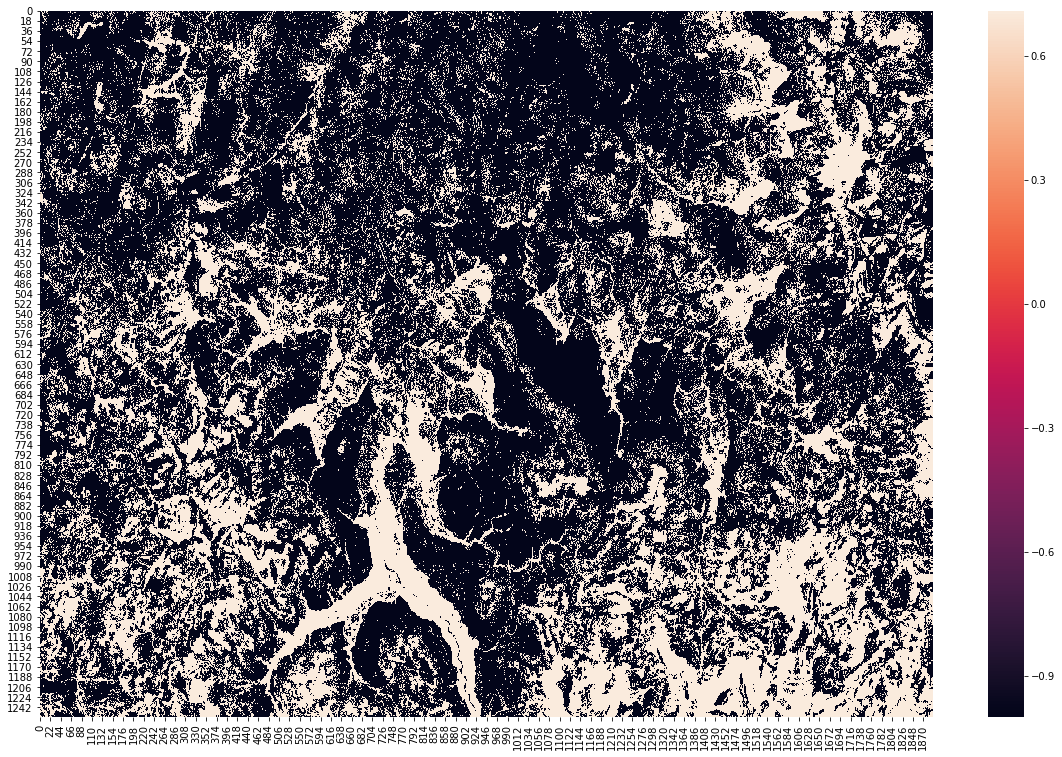

In [36]:
#stacked = np.concatenate(all_preds, axis = 0)
plt.figure(figsize=(20, 13))
stacked[np.where(stacked > thresh_p)] = 1.
stacked[np.where(stacked < thresh_p)] = -1
stacked[np.where(stacked == 1.0)] = 0.71
#stacked[np.where(np.logical_and(np.greater_equal(stacked, 0.3), np.greater_equal(0.4, stacked)))] = 0.5
sns.heatmap(stacked)
#plt.savefig('ghana2.png', dpi = 300)

In [37]:
coords = (13.540810, 38.177220) # tigray
#coords = (-1.817109, 37.477563) # makueni-2
#coords = (-2.575694, 37.949516) # makueni-3
#coords = (-2.561161, 38.096274) # makueni
#coords = (9.259359, -0.833750) # ghana
#coords = (-1.515869, 29.952997) # rwanda
#coords = (-1.455224, 30.323259) # rwanda2
#coords = (13.18158333, 2.47805556) # niger - koure salima
#coords = (13.316919, 2.581680) # niger
#coords = (10.596, 14.2722) # cameroon
#coords = (18.232495, -92.134215) # campeche
#coords = (14.231732, -89.418679) # el salvador
#coords = (-11.044091, 33.818034) # malawi
#coords = (10.385811, -1.764760) # sisala east, ghana
#coords = (10.390084, -0.846330) # west mamprusi, ghana
#coords = (10.097017, -2.439068) #uppere west
#coords = (7.398111, -1.269223) # cocoa
#coords = (7.702058, -0.709011) # brong ahafo bono east
#coords = (-20.147326, -40.837780) # Esperito santo, BR
#coords = (24.070469, 81.606926) # sidhi, india
#coords = (-22.559943, -44.186629) # Vale do Paraiba, Brazil
#coords = (-20.147320, -40.837770) # ESPERITO SANTO BR 2
#coords = (44.865106, -123.093435) # salem, oregon
#coords = (6.622101, -0.704616) # kwahu
#coords = (6.518909, -0.826008) # kwahu-large
#coords = (-6.352580, 106.677072) # jakarta
#coords = (4.179529, -74.889171) # , colombia
#coords = (-1.648663, 30.112521) #rwanda
#coords = (11.574298, -12.492513) # guinea
#coords = (5.765917, 14.791618) # baboua, CAF
#coords = (-18.960152, 47.469587) # madagascar
#coords = (9.909083, 76.253594) # Kochi, india
#coords = (16.032170, -90.144511) # Guatemala
#coords = (13.727334, -90.015579) # elsalvador imposible
#coords = (-11.749636, 27.586622) # Kafubu, DRC
#coords = (-6.272258, 36.679824) # Tanzania
#coords = (12.398014, -86.963042) # Nicaragua


coords = (coords[1], coords[0])

point = bounding_box(coords, (15*1260)-0, (10*1260)-20, expansion = 0) # -85, +135 el salv
west = point[1][0]
east = point[0][0]
north = point[0][1]
south = point[1][1]

[18900.0, 12580.0]


In [38]:
stacked[np.where(stacked < 0)] = 0.
stacked = stacked.astype(np.float32)
transform = rasterio.transform.from_bounds(west = west, south = south,
                                           east = east, north = north,
                                           width = stacked.shape[1], height = stacked.shape[1])

new_dataset = rasterio.open('../../ce-hosting/includes/tigray.tif', 'w', driver = 'GTiff',
                           height = stacked.shape[1], width = stacked.shape[1], count = 1,
                           dtype = 'float32',#str(stacked.dtype),
                           crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs',
                           transform=transform)
new_dataset.write(stacked, 1)
new_dataset.close()

In [39]:
summed = np.reshape(stacked, (stacked.shape[0] // 6, 6, stacked.shape[1] // 6, 6))
summed = np.sum(summed, (1, 3))
summed /= np.max(summed)
summed = np.clip(summed, 0, 0.7)
summed += 0.1

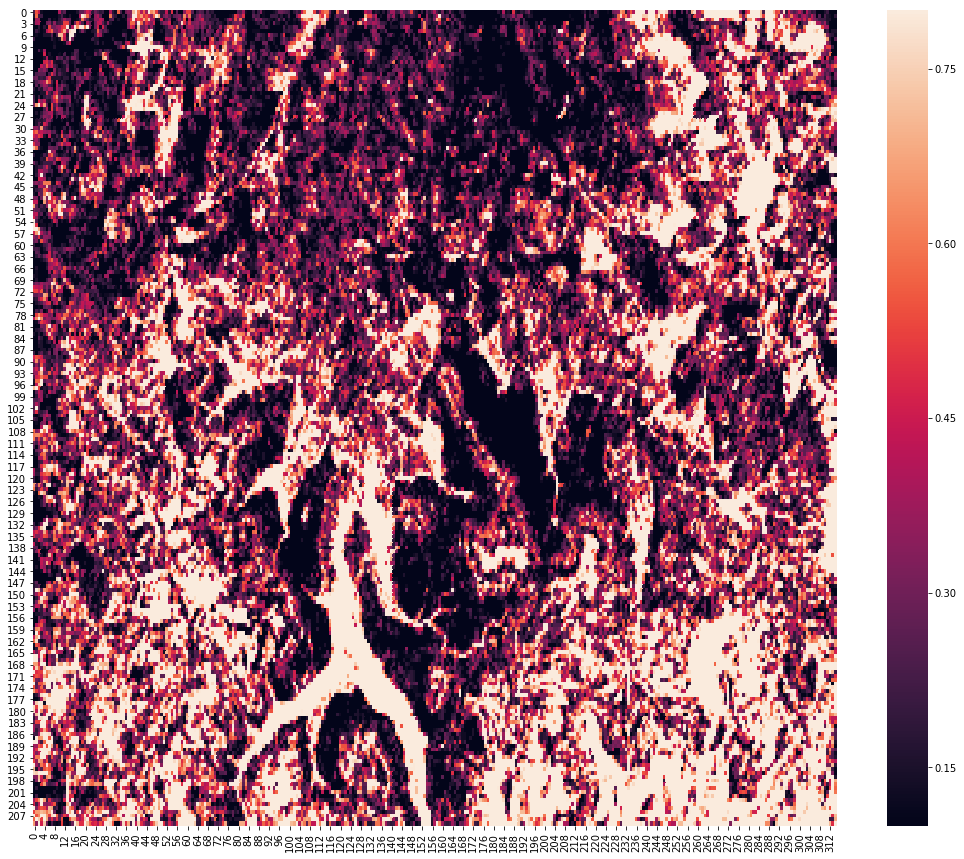

In [40]:
plt.figure(figsize=(18, 15))
sns.heatmap(summed)

In [41]:
np.min(summed)

0.1

In [42]:

summed = summed.astype(np.float32)
transform = rasterio.transform.from_bounds(west = west, south = south,
                                           east = east, north = north,
                                           width = summed.shape[1], height = summed.shape[1])

new_dataset = rasterio.open('../../ce-hosting/includes/tigray1.tif', 'w', driver = 'GTiff',
                           height = summed.shape[1], width = summed.shape[1], count = 1,
                           dtype = 'float32',#str(stacked.dtype),
                           crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs',
                           transform=transform)
new_dataset.write(summed, 1)
new_dataset.close()